In [76]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn.decomposition import PCA
from sklearn import preprocessing

from scripts.pca_fn import show_contribution, display_circles
from scripts.merge import merge_cols, complete_df
from scripts.convert import convert_to_holy_metric, find_unit

load_dotenv()
plt.style.use('Solarize_Light2')

sns.color_palette("colorblind")


# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100

# Comment out this line for potential high res or override max dpi
if pc_dpi > 150:
    pc_dpi = 100  # Lowering max dpi so github doesnt have a stroke every commit

# plots uploaded with over 100 dpi are too heavy


In [77]:
# Files

twenty_fifteen_bm = "data/2015-building-energy-benchmarking.csv"
twenty_sixteen_bm = "data/2016-building-energy-benchmarking.csv"


In [78]:
df_fifteen = pd.read_csv(twenty_fifteen_bm, dtype="unicode", low_memory=False)
df_sixteen = pd.read_csv(twenty_sixteen_bm, dtype="unicode", low_memory=False)


In [79]:
print("info : ", df_fifteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   OSEBuildingID                                                  3340 non-null   object
 1   DataYear                                                       3340 non-null   object
 2   BuildingType                                                   3340 non-null   object
 3   PrimaryPropertyType                                            3340 non-null   object
 4   PropertyName                                                   3340 non-null   object
 5   TaxParcelIdentificationNumber                                  3338 non-null   object
 6   Location                                                       3340 non-null   object
 7   CouncilDistrictCode                                            3340 n

In [80]:
print("info : ", df_sixteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   OSEBuildingID                    3376 non-null   object
 1   DataYear                         3376 non-null   object
 2   BuildingType                     3376 non-null   object
 3   PrimaryPropertyType              3376 non-null   object
 4   PropertyName                     3376 non-null   object
 5   Address                          3376 non-null   object
 6   City                             3376 non-null   object
 7   State                            3376 non-null   object
 8   ZipCode                          3360 non-null   object
 9   TaxParcelIdentificationNumber    3376 non-null   object
 10  CouncilDistrictCode              3376 non-null   object
 11  Neighborhood                     3376 non-null   object
 12  Latitude                         3

In [81]:
id_fifteen_list = list(df_fifteen["OSEBuildingID"])
id_sixteen_list = list(df_sixteen["OSEBuildingID"])

only_in_fifteen = [ident for ident in id_fifteen_list if ident not in id_sixteen_list]
only_in_sixteen = [ident for ident in id_sixteen_list if ident not in id_fifteen_list]

print(
    f"""{len(only_in_fifteen)} batiments ne sont présents que dans le benchmark 2015,\
 et {len(only_in_sixteen)} batiments ne sont présents que dans le benchmark 2016 """
  )


56 batiments ne sont présents que dans le benchmark 2015, et 92 batiments ne sont présents que dans le benchmark 2016 


In [82]:
col_onl_fifteen = [col for col in df_fifteen.columns if col not in df_sixteen.columns]

col_onl_sixteen = [col for col in df_sixteen.columns if col not in df_fifteen.columns]

print("Nombre de variables non communes aux deux datasets : ", len(col_onl_fifteen) + len(col_onl_sixteen))


Nombre de variables non communes aux deux datasets :  19


In [83]:
print(col_onl_sixteen)


['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [84]:
print(col_onl_fifteen)


['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes']


# Avant propos : 
Meme si l'etude se porte sur des batiments non residentiels, certaines comparaisons, notamment taille/energie, sont interessantes car elles permettent de comparer deux sous categorie du meme groupe (dans l'etude : mid rise/ high rise) <br>
Les modeles ne seront pas basés sur les batiments d'habitation, mais l'analyse exploratoire utilisera ces données.

## Premier constat : 

- 1 : Les dataset n'affichent des valeurs manquantes pour des variables secondaires (i.e. : SecondLargestPropertyUseType)
- 2 : Certaines propriétés ne sont présentes que dans un des deux dataset : elles devront être ignorés si l'on utilise une analyse d'évolution dans le temps
- 3 : Certaines variables ne sont pas presentes dans les deux datasets. (Ou changement de denomination : Address -> Location ?, Typos : Zip Code vs Zipcode)
- 4 : Les variables : city et state peuvent être supprimées : toutes les propriétés se trouvent à Seattle, dans l'Etat de Washington. Inutile d'alourdir les datasets.
- 5 : 56 batiments ne sont présents que dans le benchmark 2015, et 92 batiments ne sont présents que dans le benchmark 2016. Ils seront ignorés.
- --> Certaines variables ont le label "WN" (Weather Normalized). Meme si cette donnée n'est pas quantifiable sans une analyse météo précise, il est clair que certaines entreprises utilisent sciemment certains materiaux ou méthodes de construction dont les propriétés face aux phénomèmes météorologiques sont suffisamment remarquables pour que la difference ne soit pas ignorée dans cette étude ; Ainsi, certaines données afficheront une meilleure (ou moins bonne) efficacite energetique face a certaines conditions. Cela ne doit pas etre ignore meme si complique a quantifier.

<hr> 

## Allegement et conversions :

- 0 : Suppression des outliers, les metadonnées n'apportent pas d'information spécifique sur la définition d'outlier
- 1 : Plusieurs variables sont inutiles au datasets en general (Droplist)
- 2 : Certaines variables sont inutiles à l'étude et alourdissent inutilement le dataset mais peuvent être pertinentes pour décrire le batiment ou obtenir plus d'informations, elles sont écartées (df_meta)
- 3 : Le format d'adresse sur les données de 2015 est différent de celles de 2016 : compression des données de 2016 pour conformer au modèle du dataset 2015 (compress cols)
- 4 : Conversion des données au système métrique / international


In [85]:
df_sixteen = df_sixteen[df_sixteen["Outlier"].isna()]
df_fifteen = df_fifteen[df_fifteen["Outlier"].isna()]


In [86]:
rename_sixteen = {
    "Comments": "Comment",
    "TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)",
    "GHGEmissionsIntensity": "GHGEmissionsIntensity(kgCO2e/ft2)",
    }

droplist = [
    "Zip Codes", "Zipcode", "SPD Beats", "2010 Census Tracts", "City Council Districts",
    "Seattle Police Department Micro Community Policing Plan Areas", "OtherFuelUse(kBtu)",  # OtherFuelUse not present in both datasets
    "SPD Beats", "CouncilDistrictCode", "Outlier", "DataYear", "ZipCode", "NaturalGas(therms)",  # Natural gas already present in another unit
    ]

# Columns not relevant to study but informative on the properties
meta_df_cols = [
    "TaxParcelIdentificationNumber", "YearsENERGYSTARCertified", "Comment", "Location", "OSEBuildingID",
    "PrimaryPropertyType", "PropertyName", "YearBuilt"
    ]

meta_keep = ["OSEBuildingID", "PrimaryPropertyType", "PropertyName", "YearBuilt"]

compress_cols = ["Address", "City", "State", "Latitude", "Longitude"]


In [87]:
df_fifteen.drop(columns=droplist, errors="ignore", inplace=True)
df_sixteen.drop(columns=droplist, errors="ignore", inplace=True)


In [88]:
df_sixteen["Location"] = np.nan

merge_cols(origin_col_list=compress_cols, target_col_name="Location", dataframe=df_sixteen)

df_sixteen.drop(columns=compress_cols, inplace=True)


In [89]:
df_sixteen.rename(columns=rename_sixteen, inplace=True)

for col in df_sixteen.columns:
    if col not in df_fifteen.columns:
        raise BaseException("Mismatch")


In [90]:
meta_df_fifteen = df_fifteen[meta_df_cols]
meta_df_sixteen = df_sixteen[meta_df_cols]

meta_drop = [col for col in meta_df_cols if col not in meta_keep]

df_fifteen.drop(columns=meta_drop, inplace=True)
df_sixteen.drop(columns=meta_drop, inplace=True)


In [91]:
unit_stop_chars = ["(", ")", "GFA"]

manual_ignore = ["Electricity(kWh)", "GHGEmissions(MetricTonsCO2e)", "GHGEmissionsIntensity(kgCO2e/ft2)"]

unit_cols = [col for col in df_fifteen.columns if (any(char in col for char in unit_stop_chars) and col not in manual_ignore)]


In [92]:
unit_dict = dict.fromkeys(unit_cols)

for col in unit_dict.keys(): 
    unit = find_unit(var_name=col, convert=True)["converted_unit"]

    if "GFA" in col:
        new_name = col.replace("GFA", "Area(SquareMetre)")
    elif ("("and ")") in col:
        start, end = col.find("("), col.find(")")
        before = col[:start + 1]
        after = col[end:]
        new_name = f"{before}{unit}{after}"
    
    df_fifteen[new_name] = np.nan
    df_sixteen[new_name] = np.nan
    unit_dict[col] = new_name

for key, value in unit_dict.items():

    for index, series in df_fifteen.iterrows():
        df_fifteen.at[index, value] = convert_to_holy_metric(data=series[key], var_name=key)
    for index, series in df_sixteen.iterrows():
        df_sixteen.at[index, value] = convert_to_holy_metric(data=series[key], var_name=key)

df_fifteen.drop(columns=unit_dict.keys(), inplace=True)
df_sixteen.drop(columns=unit_dict.keys(), inplace=True)


In [93]:
# Suppression des batiments non communs aux deux datasets via leur ID

df_fifteen = df_fifteen[~df_fifteen["OSEBuildingID"].isin(only_in_fifteen)]

df_sixteen = df_sixteen[~df_sixteen["OSEBuildingID"].isin(only_in_sixteen)]


## Analyse des données :
- 1.a : Représentation des batiments en fonction de leurs dates de construction.
- 1.b : Visualisation des statistiques principales de la variable : Energie par metre carré
- 1.c : Paire 1 : Date de construction et utilisation en energie par metre carré.
- 2.a : Repartition de la note Energy Star au sein des données.
- 2.b : Paire 2 : Note Energy Star en fonction de l'energie par metre carré.
- 3 : Paire 3 : Energy Star en fonction de l'année de construction.
- 4 : Représentation Property Type/Utilisation Energie

### Cette analyse permettra de :
 - Visualiser "l'age" du paysage de Seattle
 - Contextualiser la mesure de la consommation d'énergie au metre carré, et sa possible relation avec l'age des batiments
 - Avoir une meilleure comprehension de la variable Energy Star et de la présenter face à l'age des batiments et de leur consommation en energie

<hr>

# I : Analyse d'un seul dataset

# II : Reduction de dimension, normalisation et fusion des datasets

<hr>

# I : Analyse séparée
## 1 : L'age des batiments et leur consommation en energie
### 1.a : L'age du paysage de Seattle

In [94]:
# We can use df_16 since the data is more recent for energy use and didnt change for construction date

data_age = list(df_sixteen["YearBuilt"].astype(int))
oldest = min(data_age)
youngest = max(data_age)

print(f"Le plus ancien batiment date de {oldest}, le plus récent (en 2016) date de {youngest}")


Le plus ancien batiment date de 1900, le plus récent (en 2016) date de 2015


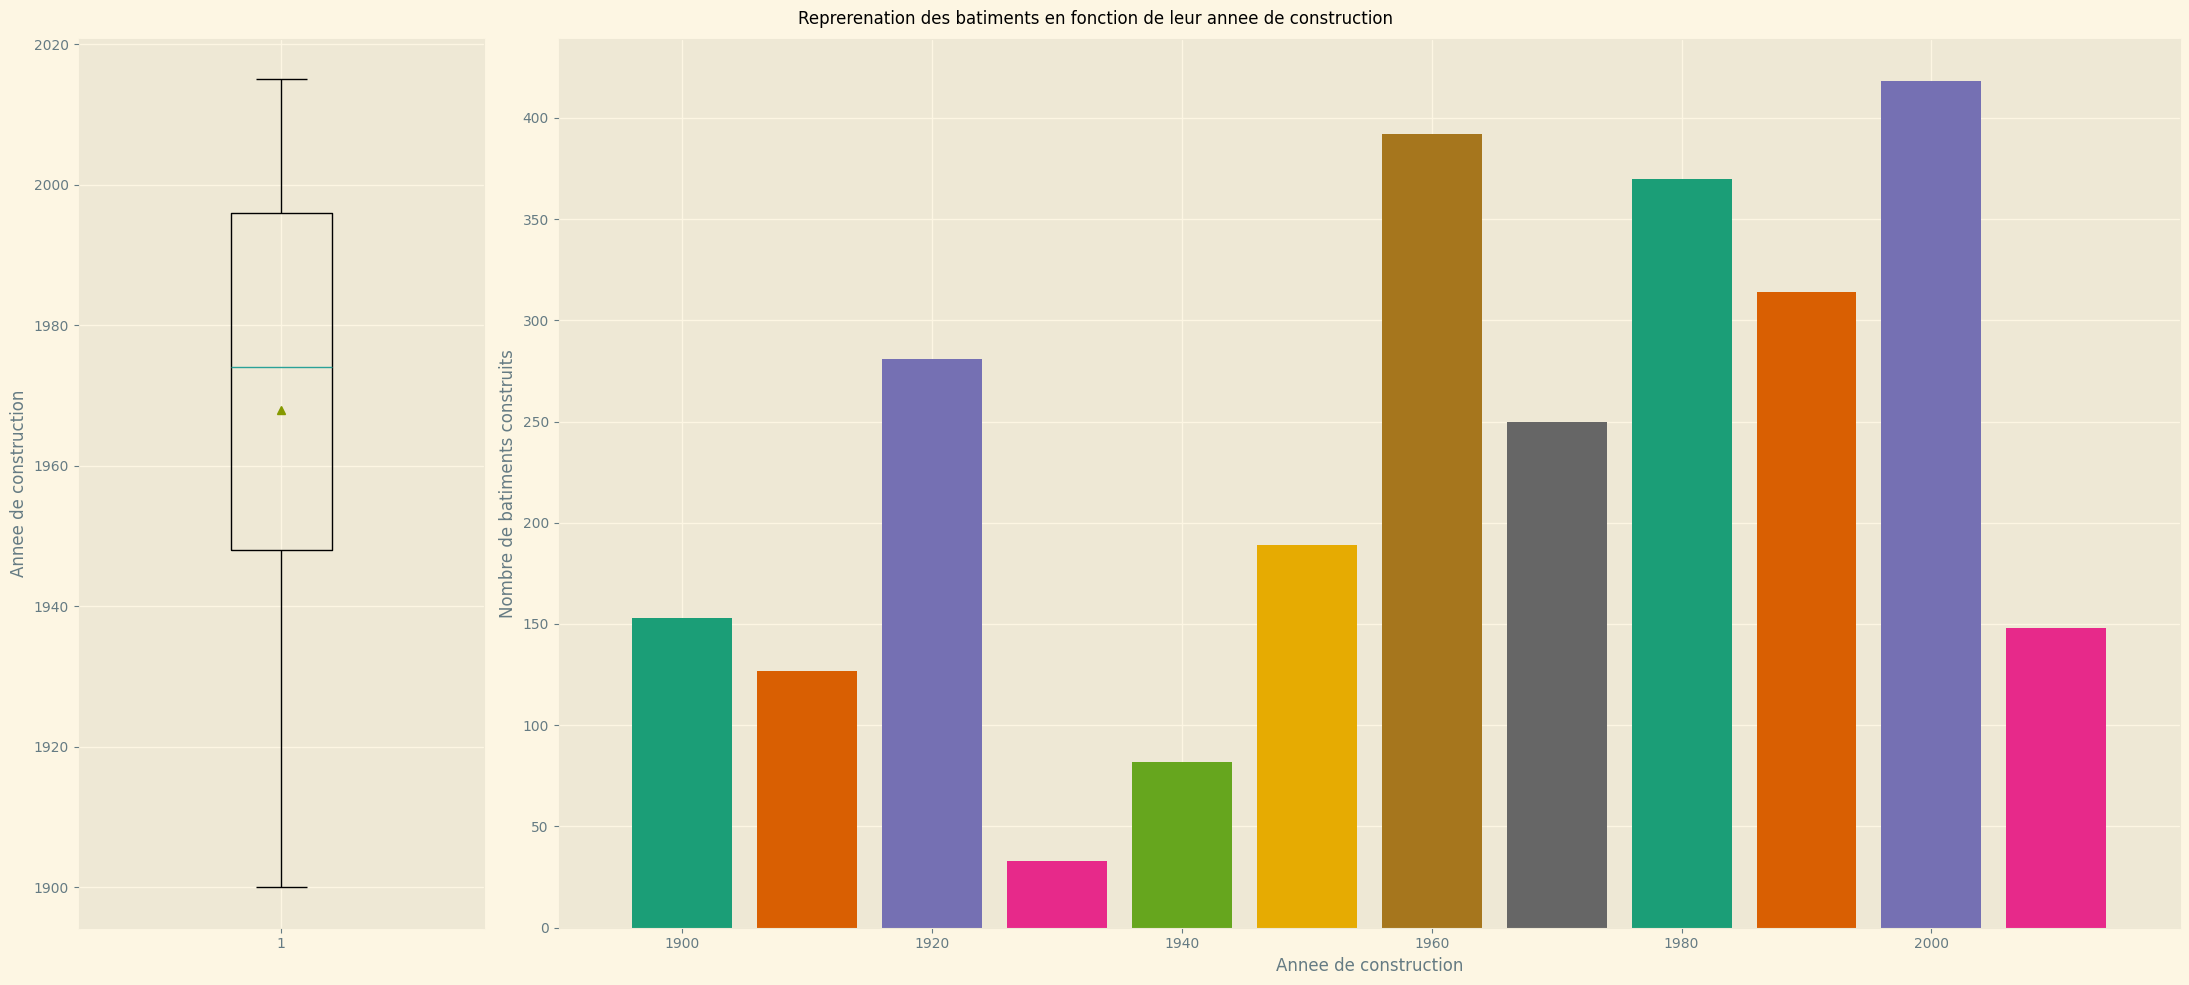

In [95]:
decades = np.arange(1900, 2020, 10)

building_per_decade = dict.fromkeys(decades)

for decade in building_per_decade.keys():
    built = len([year for year in data_age if (year > decade and year < decade + 10)])
    building_per_decade[decade] = built

used_cmap = plt.get_cmap("Dark2")

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 10),
    gridspec_kw={"width_ratios": [1, 4]},
    dpi=pc_dpi
    )

ax1.boxplot(data_age, showmeans=True, widths=0.25)

ax2.bar(building_per_decade.keys(), height=building_per_decade.values(), width=8, color=used_cmap.colors)
# ax2 lineplot

###
# Titles & Labels
ax1.set_ylabel("Annee de construction")
ax2.set_ylabel("Nombre de batiments construits")
ax2.set_xlabel("Annee de construction")
fig.suptitle("Reprerenation des batiments en fonction de leur annee de construction")
fig.tight_layout()
#
###

plt.show()


Comment Zone

## 1.b Visualisation des statistiques principales de la variable : Energie par metre carré

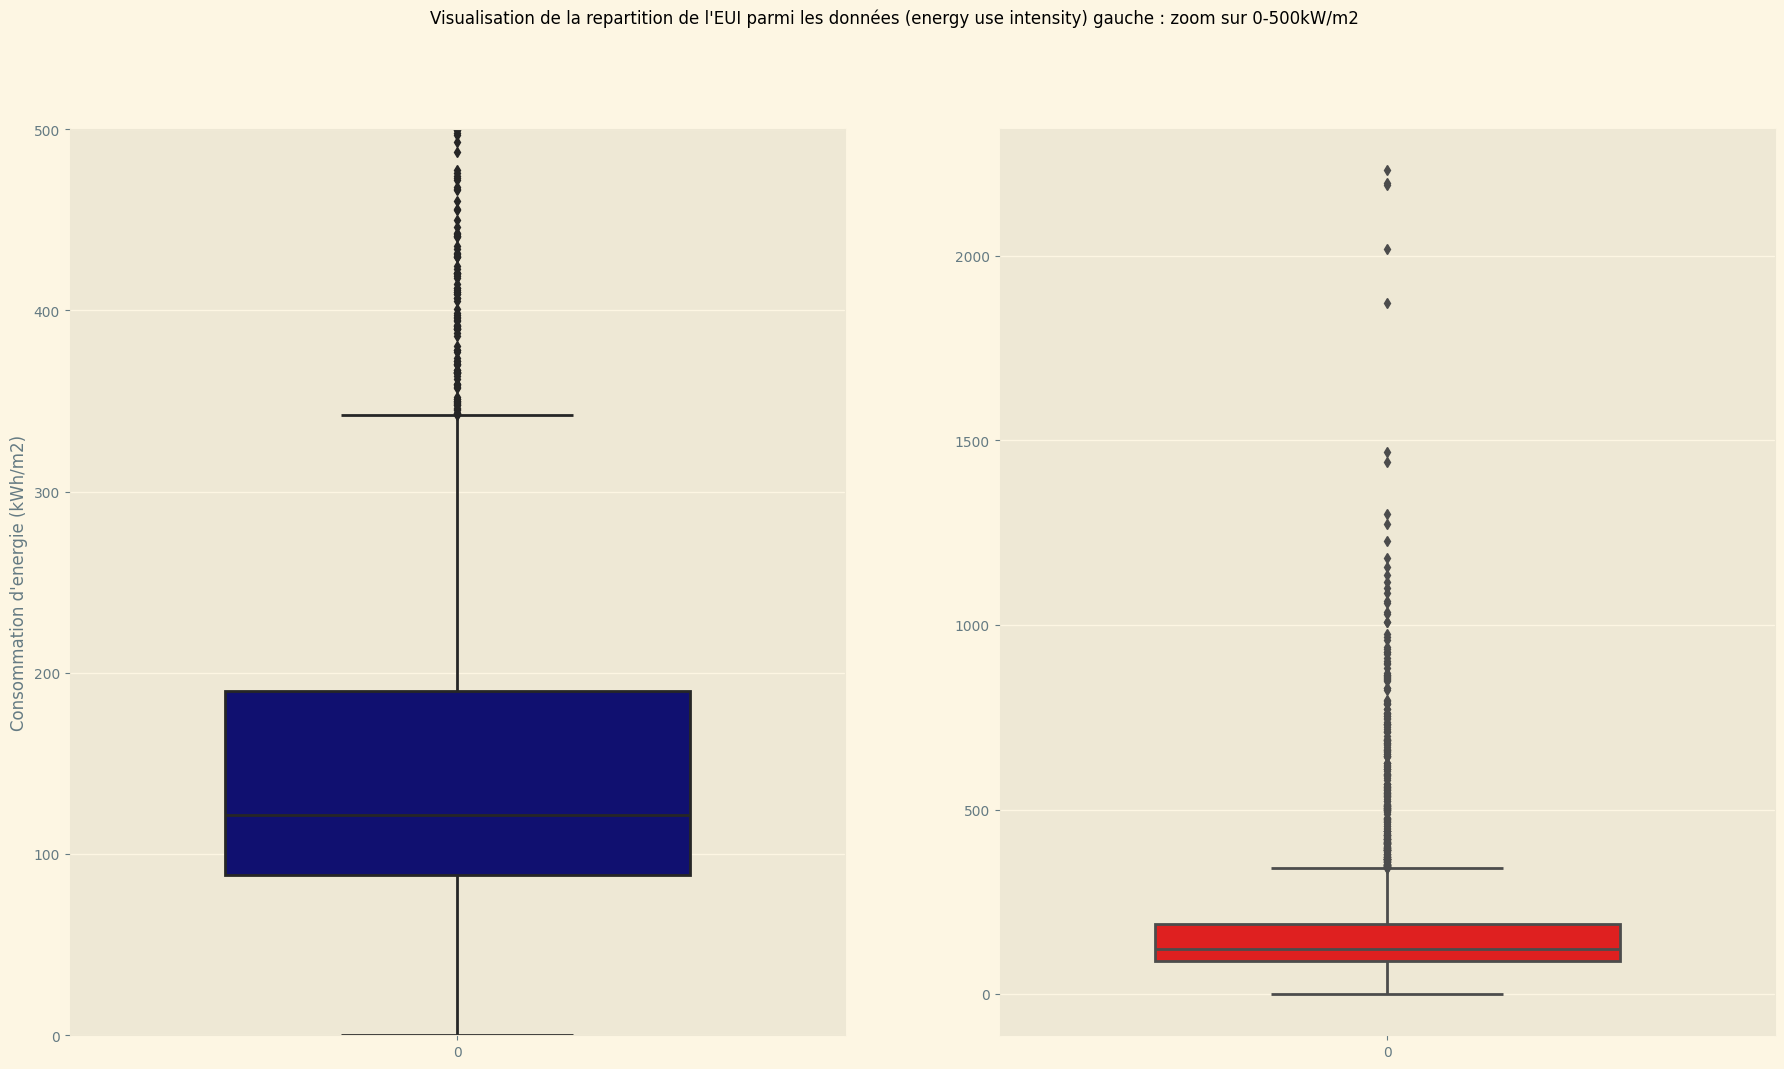

count    3248.000000
mean      170.934392
std       169.353027
min         0.000000
25%        88.328520
50%       121.767169
75%       189.985184
max      2231.241469
Name: SiteEUI(kWh/m2), dtype: float64


In [96]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
    )

site_eui_data = list(df_sixteen["SiteEUI(kWh/m2)"].values.astype(float))

sns.boxplot(data=site_eui_data, width=0.6, ax=ax1, color="navy")
ax1.set_ylim(0, 500)  # High number of outliers, cf describe
sns.boxplot(data=site_eui_data, width=0.6, ax=ax2, color="red")
# fig.tight_layout()

###
# Titles/Lables
ax1.set_ylabel("Consommation d'energie (kWh/m2)")
fig.suptitle("Visualisation de la repartition de l'EUI parmi les données (energy use intensity)\
 gauche : zoom sur 0-500kW/m2")
#
###

plt.show()

print(df_sixteen["SiteEUI(kWh/m2)"].astype(float).describe())


# Analyse :

- 1 : Les outliers sont extrèmement nombreux, uniquement dans les utilisations "hautes"
- 2 : La majorité des batiments ont une EUI entre 87 et 190 kWh/m2, 170 en moyenne.
- 3 : L'élimination de batiments via la methode interquartile peut être viable, la reduction de dimension via ACP peut également être une piste

Corrections requises : typos et \n

### Possibilité de valider et ameliorer ce groupement via Kmeans

### 1.c : Paire 1 : Date de construction et utilisation en energie par metre carré.

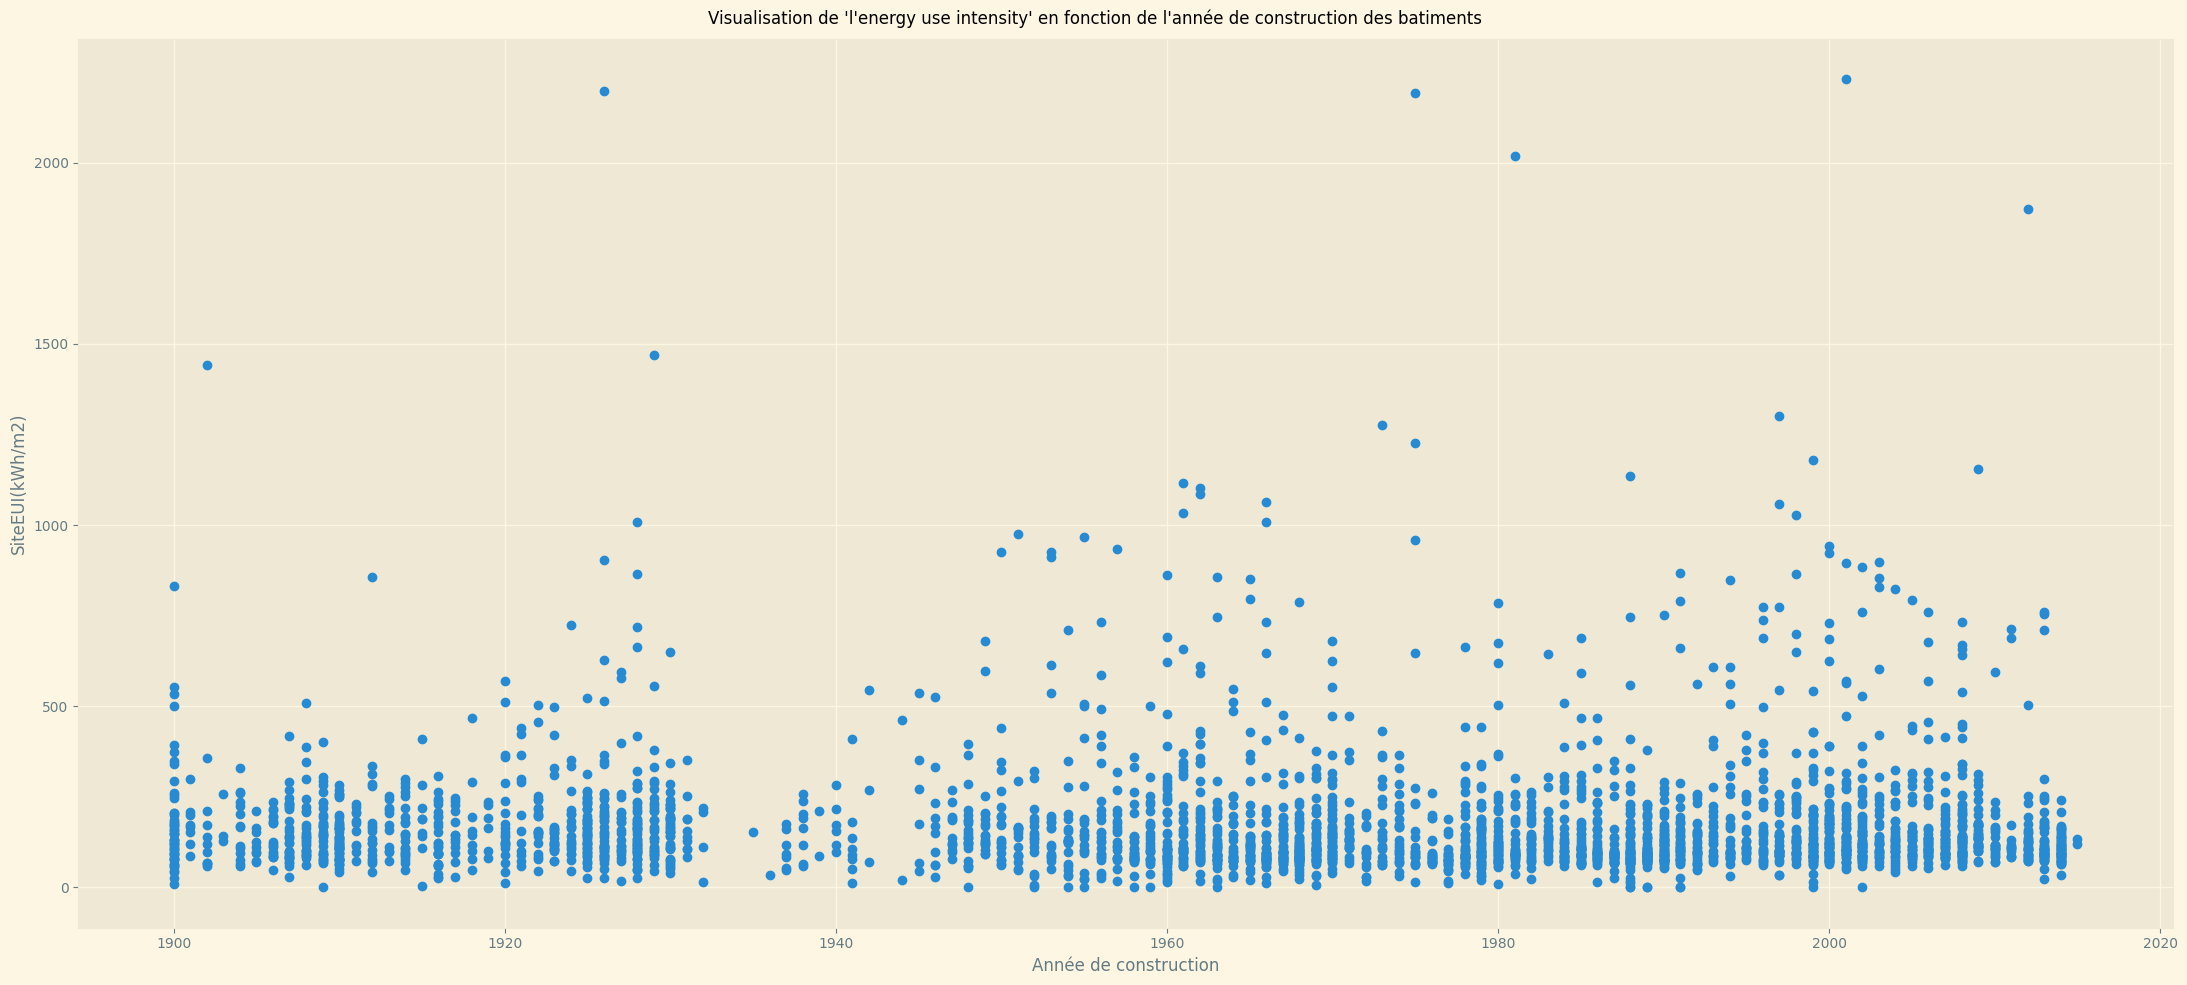

In [97]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1.scatter(
    x=df_sixteen["YearBuilt"].astype(int).values,
    y=df_sixteen["SiteEUI(kWh/m2)"].values.astype(float),
    )

###
# Titles/Lables
ax1.set_ylabel("SiteEUI(kWh/m2)")
ax1.set_xlabel("Année de construction")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de l'année de construction des batiments")
#
###
fig.tight_layout()
plt.show()


### Observation : 
- L'age des batiments ne semble pas avoir d'impact sur leur intensité d'utilisation énergétique. On peut emettre l'hypothèse que les batiments les plus anciens ont été modernisés pour avoir une consommation energetique plus responsable.
- Que cette hypothèse soit vraie ou fausse, le graphique ci dessus ne semble pas montrer une corréllation claire entre l'age d'un batiment et l'intensité de son utilisation energetique.
- On peut verifier cela avec un diagramme en barres, qui serait plus pertinent pour visualiser ces chiffres.

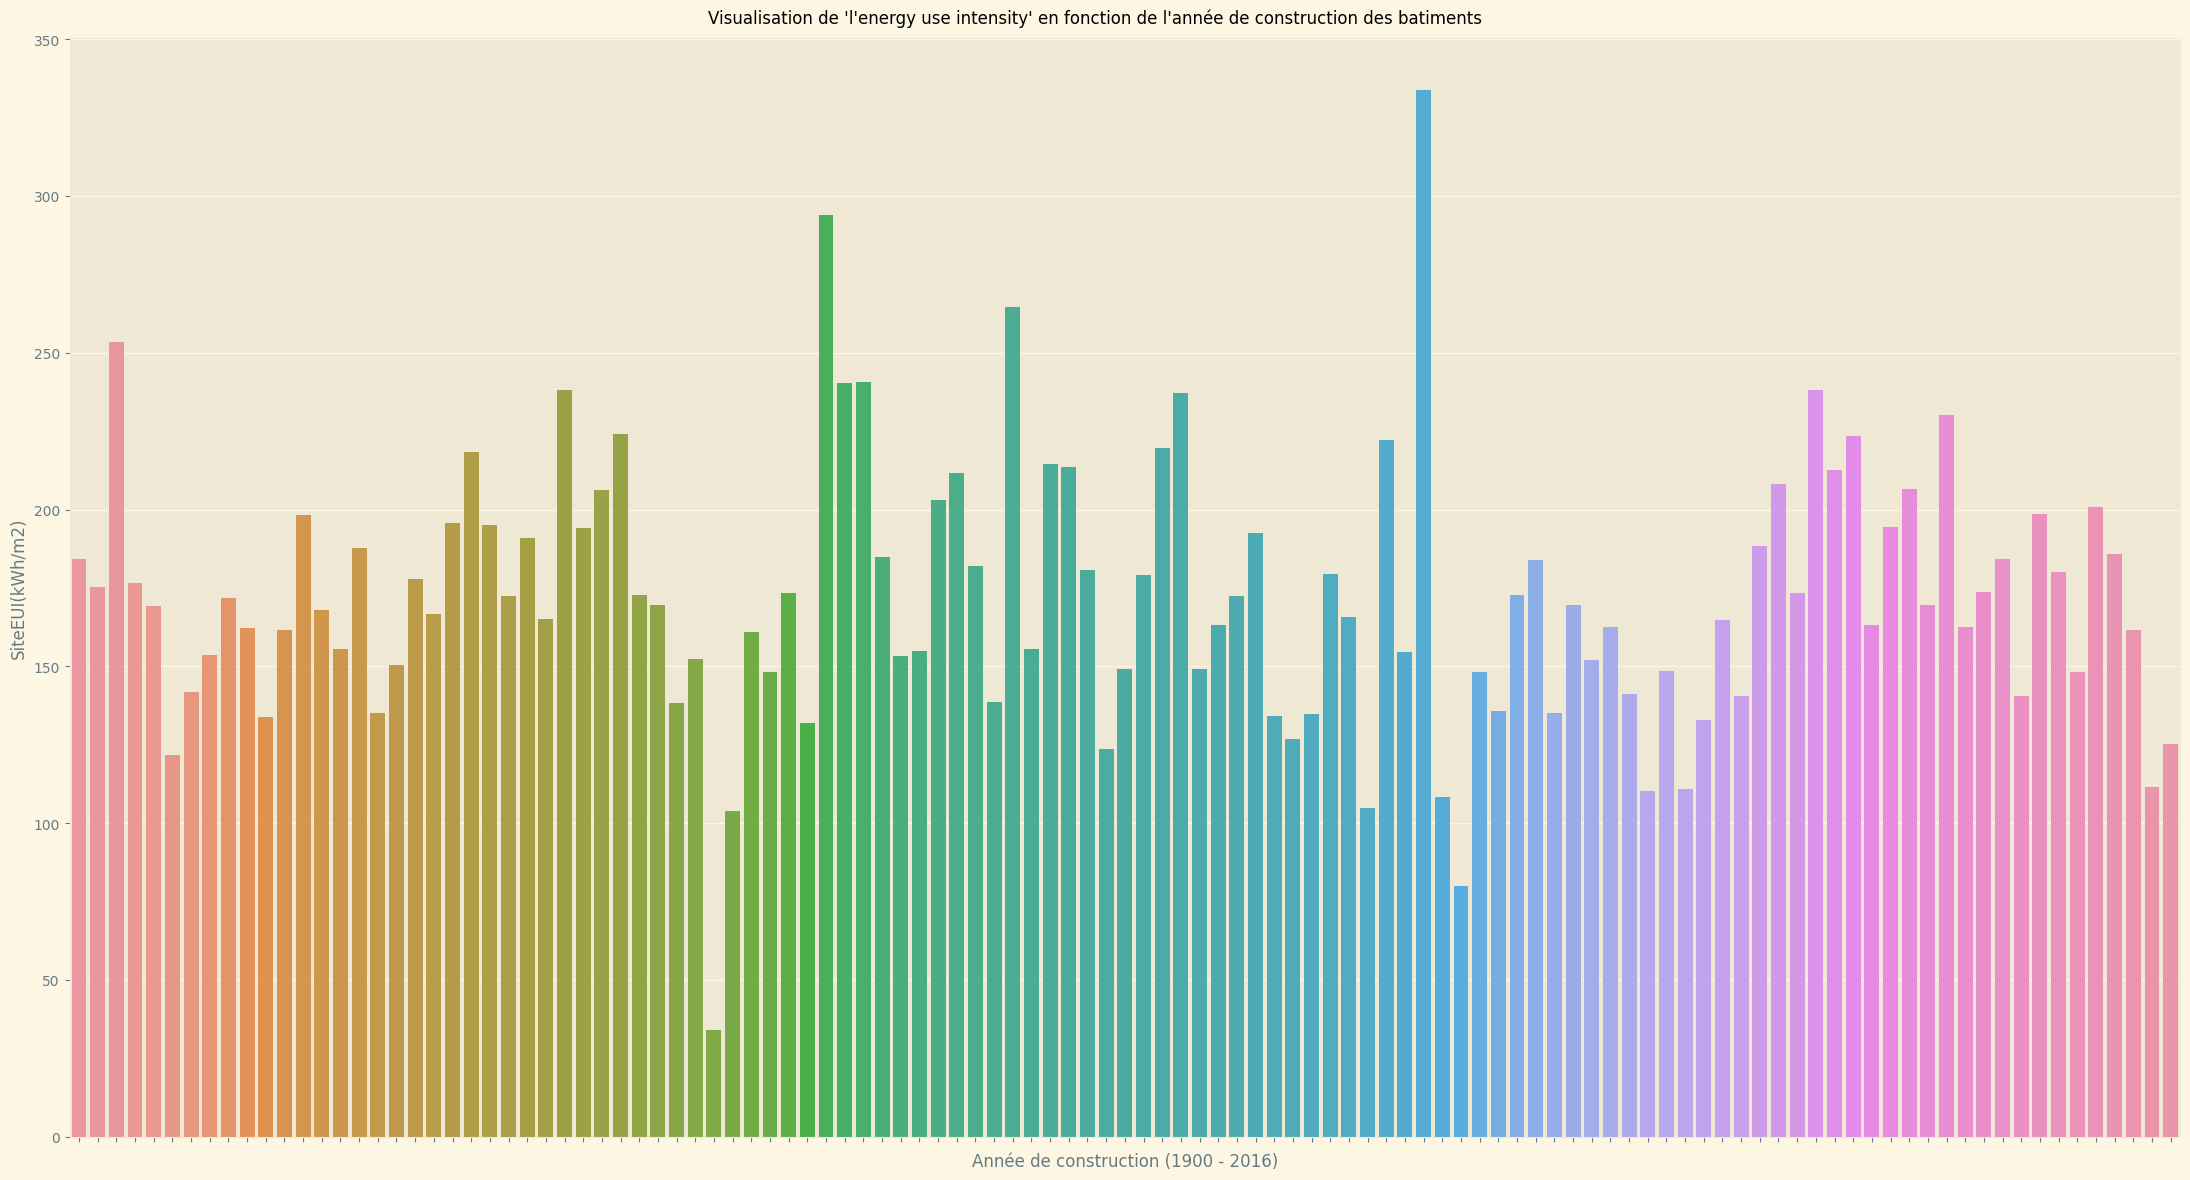

In [98]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=df_sixteen["YearBuilt"].astype(int).values,
    y=df_sixteen["SiteEUI(kWh/m2)"].values.astype(float),
    ci=None
)

###
# Titles/Lables
ax1.set_xticklabels([])
ax1.set_ylabel("SiteEUI(kWh/m2)")
ax1.set_xlabel("Année de construction (1900 - 2016)")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de l'année de construction des batiments")

#
###
fig.tight_layout()
plt.show()


### L'utilisation d'un autre type de visualisation confirme qu'on ne peut pas, de facon fiable, corréler l'intensité de l'utilisation energetique avec l'age d'un batiment

## 2.a La variable Energy Star au sein des données

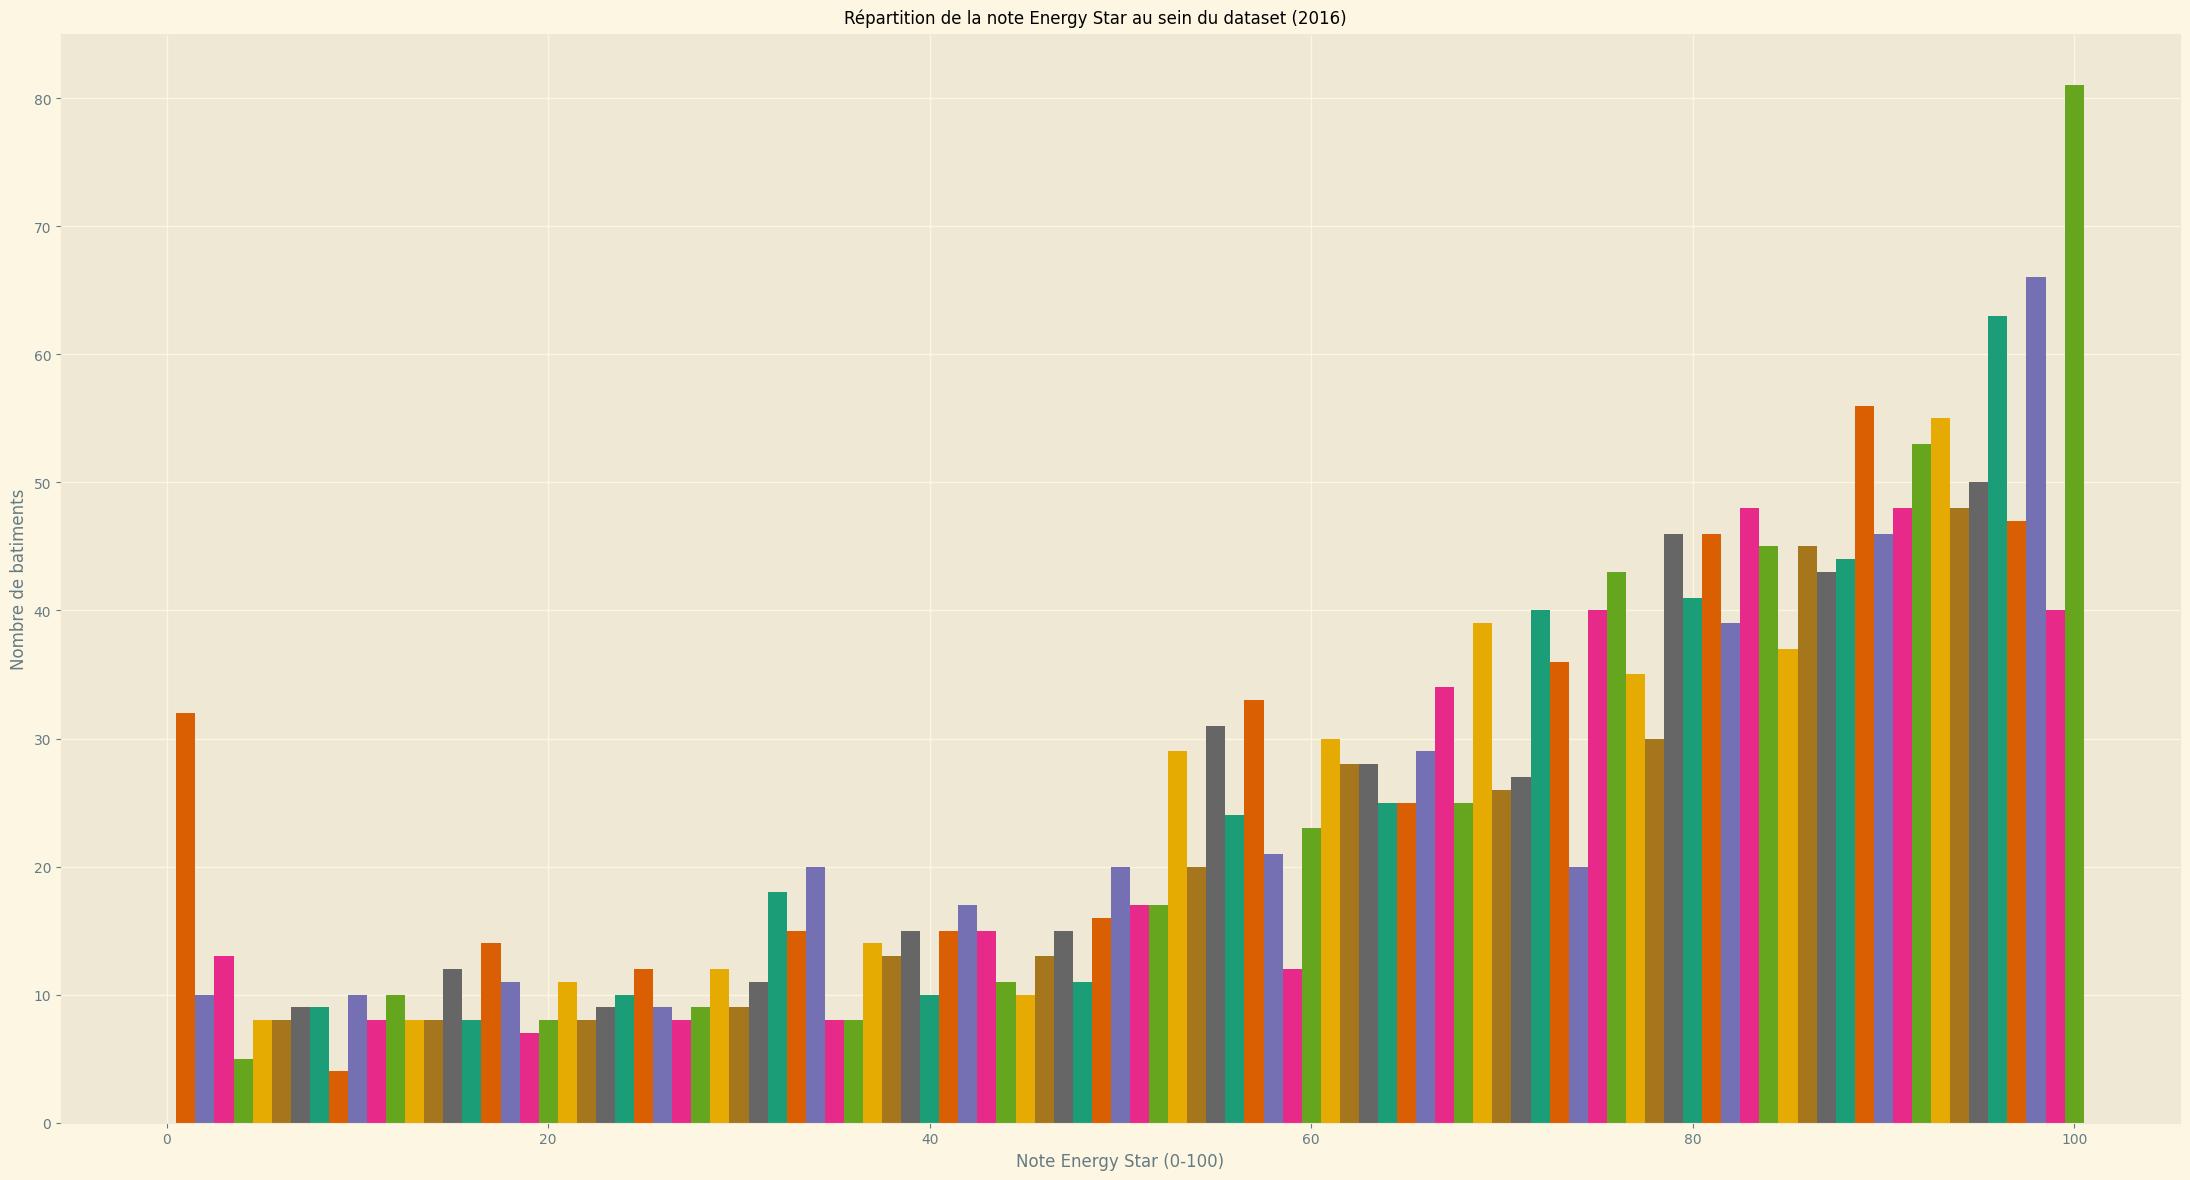

In [99]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

rated = df_sixteen[df_sixteen["ENERGYSTARScore"].notna()]
scores = list(rated["ENERGYSTARScore"].astype(int).values)
score_range = range(0, 101, 1)
scores_dict = dict.fromkeys(score_range)

for score in scores_dict.keys():
    scores_dict[score] = scores.count(score)

ax1.bar(
    x=list(scores_dict.keys()),
    height=list(scores_dict.values()),
    color=used_cmap.colors,
    width=1
    )

####
## Titles/Lables
ax1.set_ylabel("Nombre de batiments")
ax1.set_xlabel("Note Energy Star (0-100)")
fig.suptitle("Répartition de la note Energy Star au sein du dataset (2016)")
##
####

fig.tight_layout()

plt.show()


### Repartition des notes Energy Star au sein du jeu de données.

## 2.b : Paire 2 : Note Energy Star en fonction de l’énergie par mètre carré.

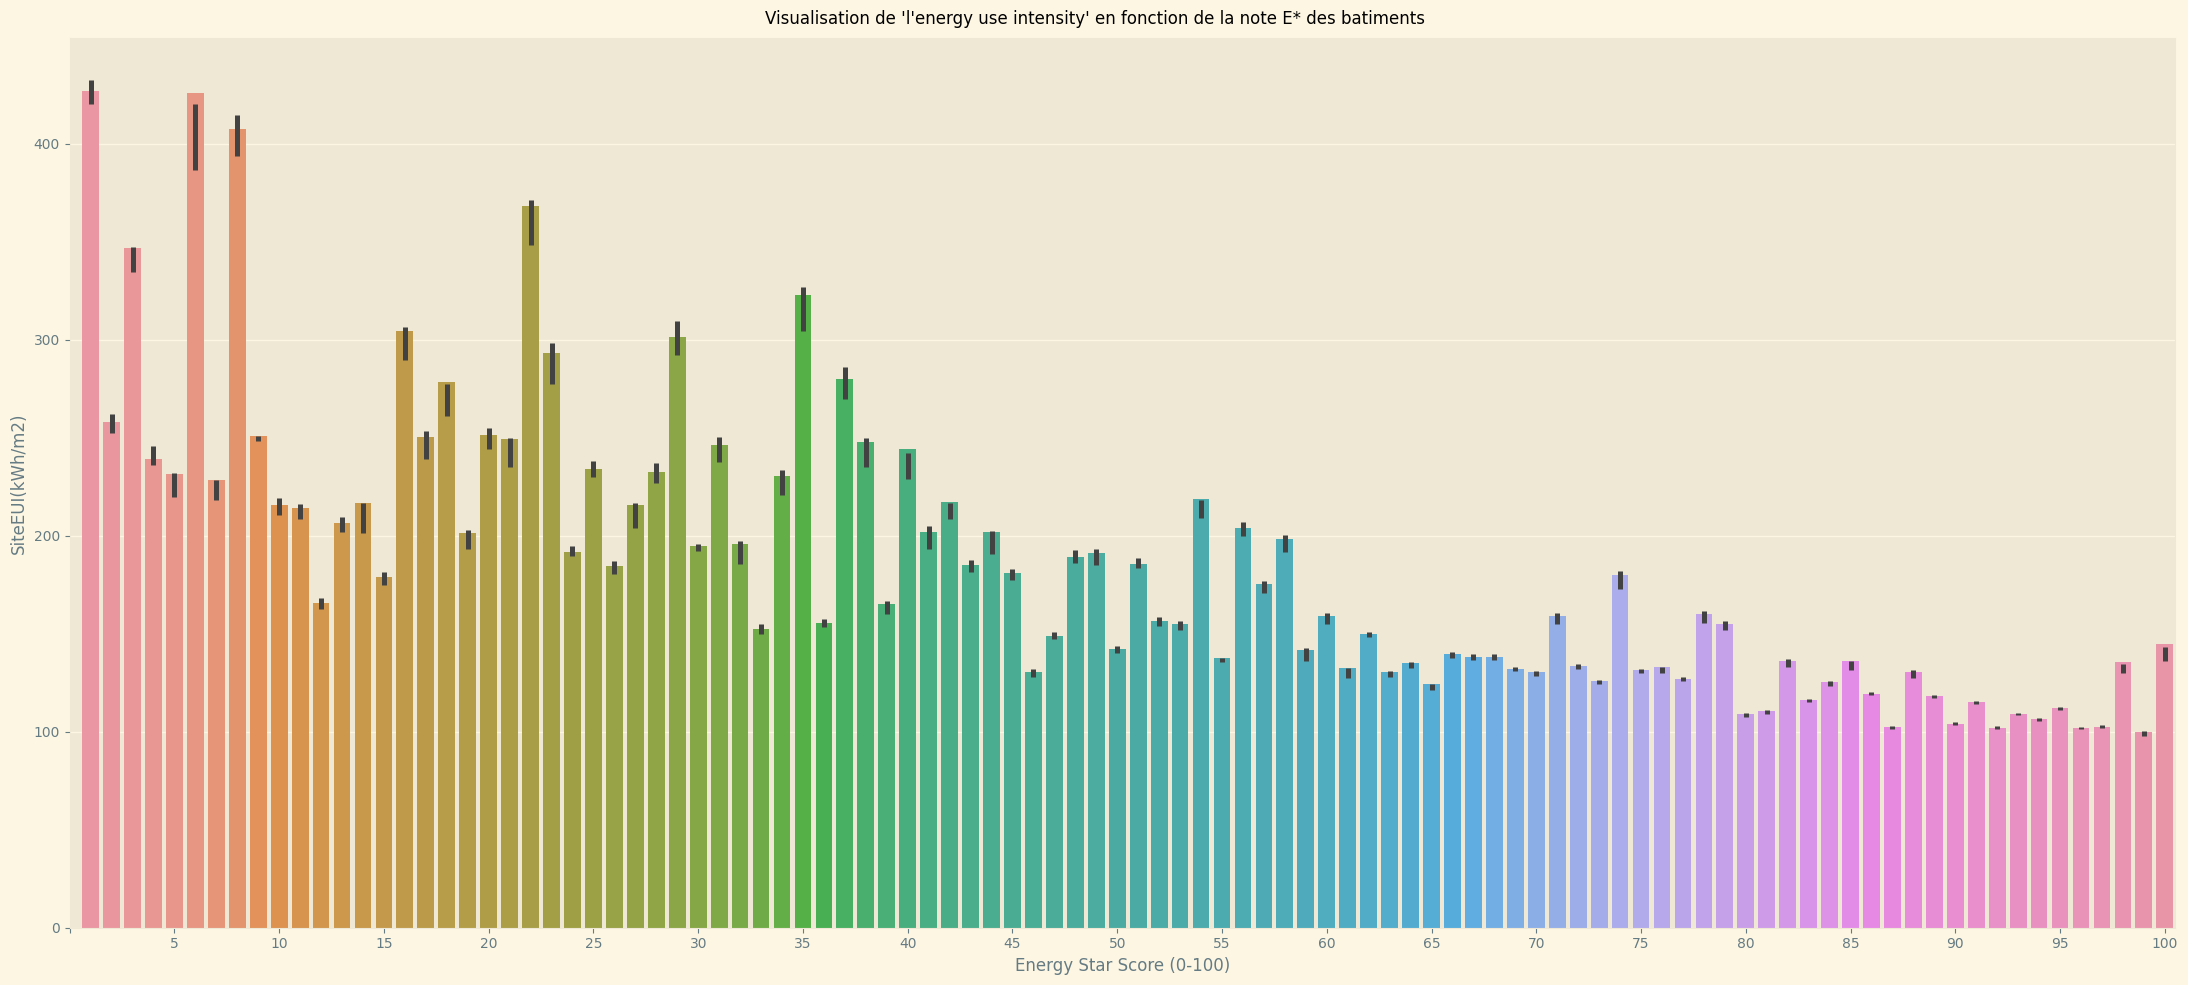

In [100]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.barplot(
    x=rated["ENERGYSTARScore"].values.astype(int),
    y=rated["SiteEUI(kWh/m2)"].values.astype(float),
    ci=10
)


###
# Titles/Lables
ax1.set_xticks(np.arange(-1, 101, 5))
ax1.set_ylabel("SiteEUI(kWh/m2)")
ax1.set_xlabel("Energy Star Score (0-100)")
fig.suptitle("Visualisation de 'l'energy use intensity' en fonction de la note E* des batiments")
#
###

fig.tight_layout()
plt.show()


### Observation 
- On peut observer ici un lien clair entre le Score Energy Star (E*) et l'intensité d'utilisation énergétique (EUI). Le lien est logique dans ce cas : le site E* explique que, entre autres, l'utilisation d'énergie est un facteur.
- Le site internet d'E* fourni également une motivation pour l'obtention de cette note : un batiment est "Energy Star Certified" lorsque sa note est supérieure ou égale à 75 (ce qui peut expliquer le pic autour de cette note : les developpeurs immobiliers ont interèt à obtenir cette certification)

## Paire 3 : Rapport entre E* et année de construction :

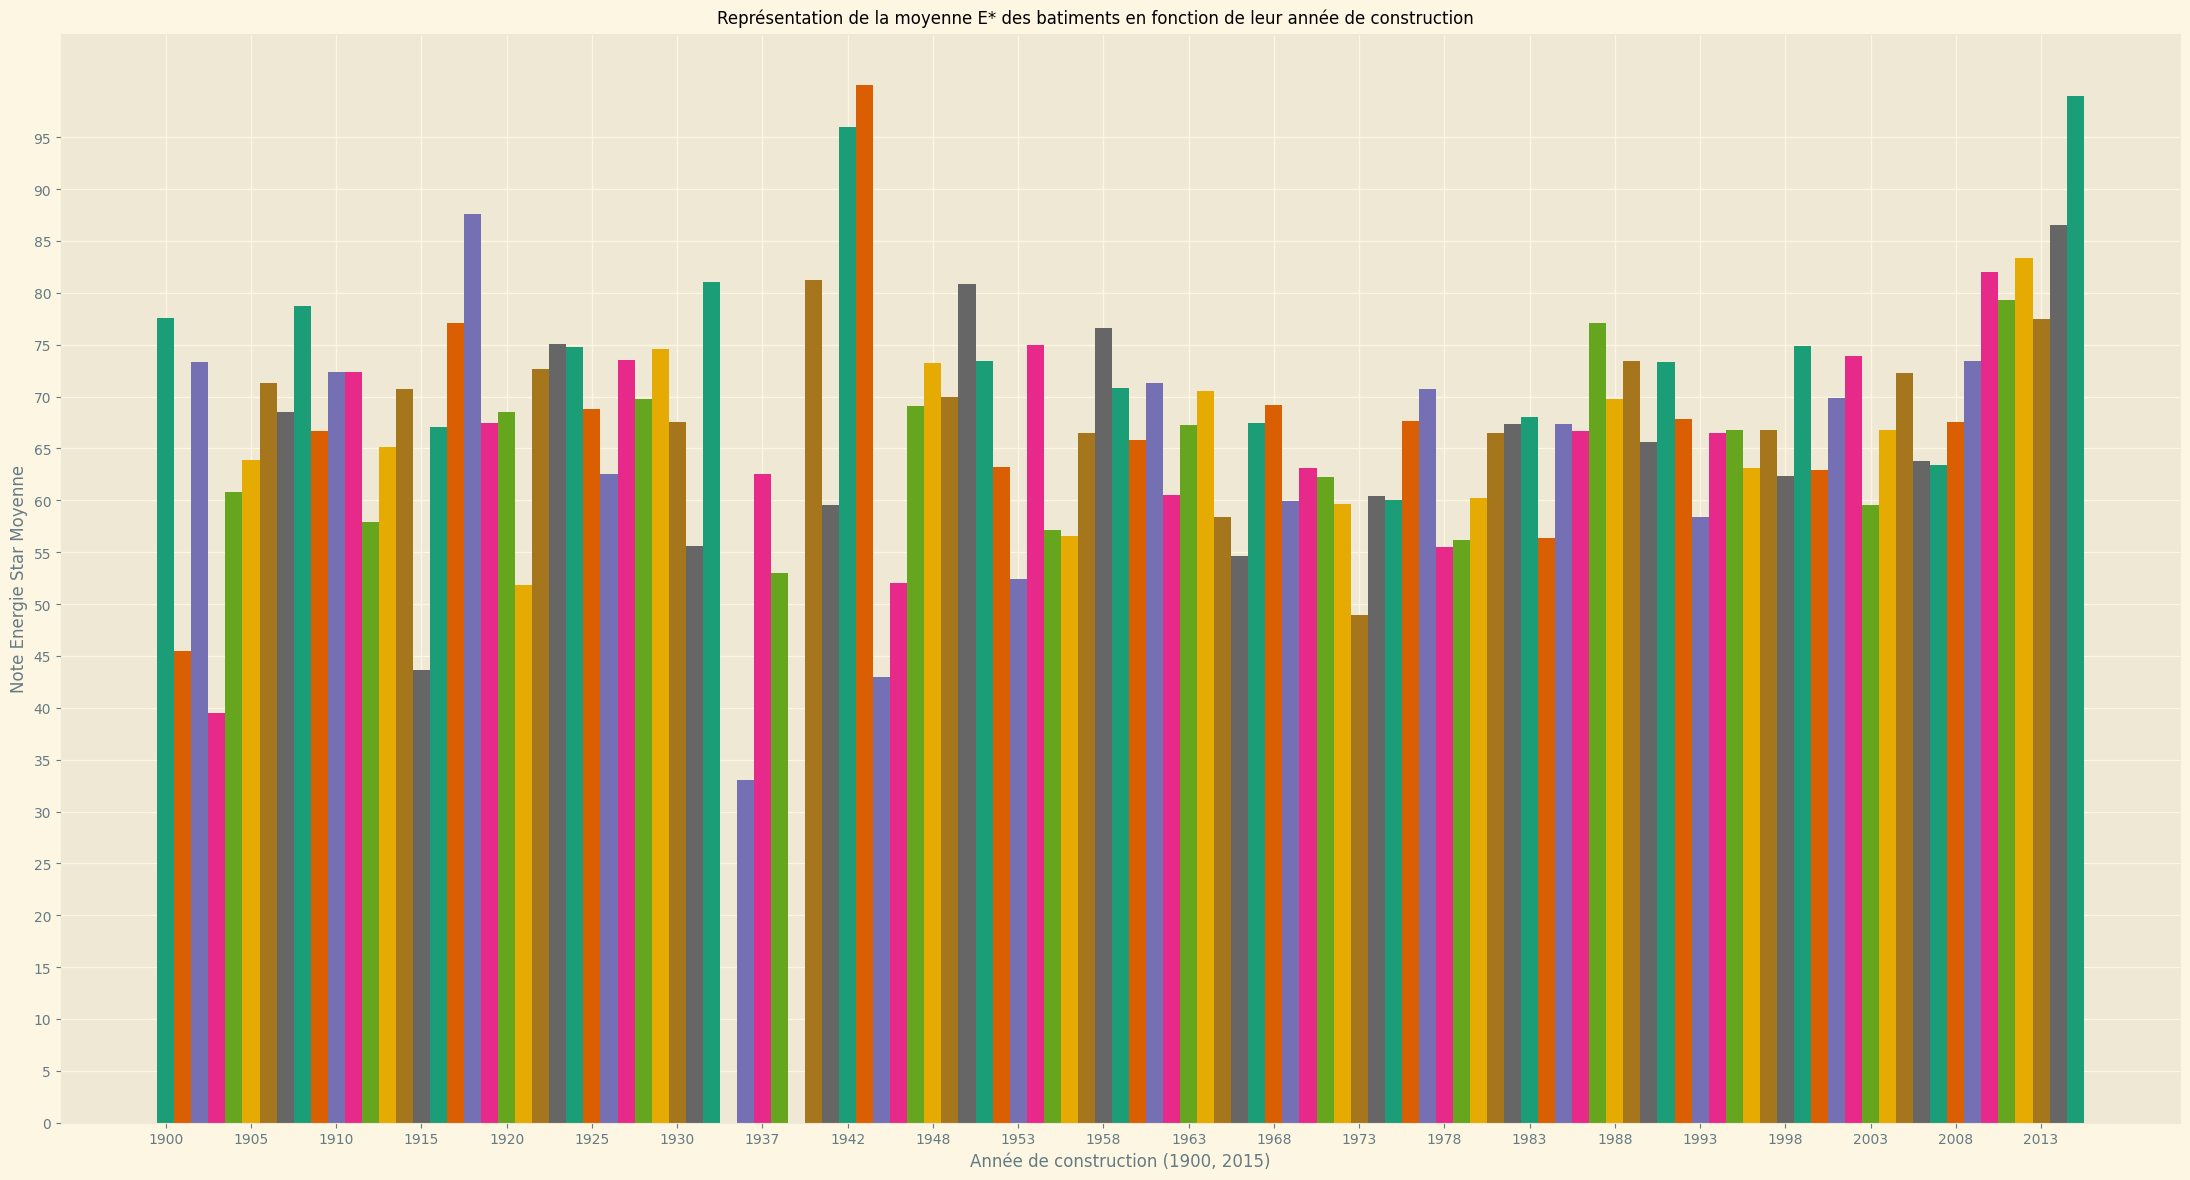

In [101]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 12),
    dpi=pc_dpi,
)

years_list = list(df_sixteen[df_sixteen["YearBuilt"].notna()]["YearBuilt"].values)
year_keys = []
for year in years_list:
    if year not in year_keys:
        year_keys.append(year)

year_keys.sort()

year_dict = dict.fromkeys(year_keys)

for key in year_dict.keys():
    temp = df_sixteen[(df_sixteen["YearBuilt"] == key) & (df_sixteen["ENERGYSTARScore"].notna())]
    scores = [int(i) for i in temp["ENERGYSTARScore"]]
    try:
        mean = sum(scores) / len(scores)
        year_dict[key] = mean
    except ZeroDivisionError:
        year_dict[key] = 0

ax1.bar(
    x=list(year_dict.keys()),
    height=list(year_dict.values()),
    color=used_cmap.colors,
    width=1,
    )

###
# Titles/Lables
ax1.set_xticks(np.arange(0, len(list(year_dict.keys())), 5))
ax1.set_yticks(np.arange(0, 100, 5))
ax1.set_ylabel("Note Energie Star Moyenne")
ax1.set_xlabel("Année de construction (1900, 2015)")
fig.suptitle("Représentation de la moyenne E* des batiments en fonction de leur année de construction")
#
###

fig.tight_layout()
plt.show()


### Observation :
- L'année de construction ne semble pas avoir d'influence sur la note E* - Cela peut venir, comme ecrit plus haut, de travaux de modernisation par exemple.

## 4 : Note E* en fonction du type de batiment étudié

In [102]:
print(2015)

uniques = df_fifteen["PrimaryPropertyType"].unique()
unique_property_fifteen_type_dict = dict.fromkeys(uniques)
for unique in unique_property_fifteen_type_dict.keys():
    unique_property_fifteen_type_dict[unique] = len(df_fifteen[df_fifteen["PrimaryPropertyType"] == unique])

unique_property_fifteen_type_dict


2015


{'Hotel': 71,
 'Other': 251,
 'Mid-Rise Multifamily': 518,
 'Mixed Use Property': 125,
 'K-12 School': 132,
 'College/University': 22,
 'Small- and Mid-Sized Office': 279,
 'Self-Storage Facility\n': 27,
 'Distribution Center': 2,
 'Large Office': 158,
 'Retail Store': 93,
 'Senior Care Community': 43,
 'Medical Office': 40,
 'Hospital': 10,
 'Residence Hall/Dormitory': 15,
 'Non-Refrigerated Warehouse': 185,
 'Distribution Center\n': 51,
 'SPS-District K-12': 4,
 'Worship Facility': 71,
 'Low-Rise Multifamily': 944,
 'Supermarket/Grocery Store': 36,
 'Laboratory': 1,
 'Self-Storage Facility': 1,
 'Refrigerated Warehouse': 13,
 'High-Rise Multifamily': 100,
 'Restaurant\n': 10,
 'Restaurant': 1}

In [103]:
uniques = df_fifteen["BuildingType"].unique()
unique_fifteen_btype_dict = dict.fromkeys(uniques)
for unique in unique_fifteen_btype_dict.keys():
    unique_fifteen_btype_dict[unique] = len(df_fifteen[df_fifteen["BuildingType"] == unique])

unique_fifteen_btype_dict


{'NonResidential': 1406,
 'Nonresidential COS': 68,
 'Multifamily MR (5-9)': 533,
 'SPS-District K-12': 96,
 'Campus': 21,
 'Multifamily LR (1-4)': 975,
 'Multifamily HR (10+)': 104}

In [104]:
print(2016)

uniques = df_sixteen["PrimaryPropertyType"].unique()
unique_property_sixteen_type_dict = dict.fromkeys(uniques)
for unique in unique_property_sixteen_type_dict.keys():
    unique_property_sixteen_type_dict[unique] = len(df_sixteen[df_sixteen["PrimaryPropertyType"] == unique])

unique_property_sixteen_type_dict


2016


{'Hotel': 73,
 'Other': 240,
 'Mid-Rise Multifamily': 534,
 'Mixed Use Property': 127,
 'K-12 School': 136,
 'University': 21,
 'Small- and Mid-Sized Office': 288,
 'Self-Storage Facility': 28,
 'Warehouse': 184,
 'Large Office': 164,
 'Senior Care Community': 44,
 'Medical Office': 39,
 'Retail Store': 89,
 'Hospital': 10,
 'Residence Hall': 15,
 'Distribution Center': 53,
 'Worship Facility': 69,
 'Low-Rise Multifamily': 965,
 'Supermarket / Grocery Store': 40,
 'Laboratory': 10,
 'Refrigerated Warehouse': 12,
 'Restaurant': 12,
 'High-Rise Multifamily': 101}

In [105]:
uniques = df_sixteen["BuildingType"].unique()
unique_property_fivteen_btype_dict = dict.fromkeys(uniques)
for unique in unique_property_fivteen_btype_dict.keys():
    unique_property_fivteen_btype_dict[unique] = len(df_sixteen[df_sixteen["BuildingType"] == unique])

unique_property_fivteen_btype_dict


{'NonResidential': 1419,
 'Nonresidential COS': 66,
 'Multifamily MR (5-9)': 549,
 'SPS-District K-12': 97,
 'Campus': 22,
 'Multifamily LR (1-4)': 995,
 'Multifamily HR (10+)': 106}

## Objectifs :

- Mettre en évidence une différence suffisamment significative pour considerer les batiments en tant que differentes classes
- Démontrer l'interêt d'une classification issue du ML (k-means par exemple)
- Accélerer la classification des batiments en se basant, si possible, partiellement sur le type de batiment

## Pre-traitement : 
- Correction des typos, chariage returns, tabulations, double espaces etc.
- Groupement manuel de types similaires manuellement, non évident pour une machine (i.e. : Lab & Senior Facility in medical)
- Elimination des types rares (--> others)

In [106]:
for key in unique_property_fifteen_type_dict.keys():
    if key not in unique_property_sixteen_type_dict.keys():
        unique_property_sixteen_type_dict[key] = "Primary Type Changed"
    elif key in unique_property_sixteen_type_dict.keys():
        pass

unique_common_ptype = unique_property_sixteen_type_dict
unique_common_ptype


{'Hotel': 73,
 'Other': 240,
 'Mid-Rise Multifamily': 534,
 'Mixed Use Property': 127,
 'K-12 School': 136,
 'University': 21,
 'Small- and Mid-Sized Office': 288,
 'Self-Storage Facility': 28,
 'Warehouse': 184,
 'Large Office': 164,
 'Senior Care Community': 44,
 'Medical Office': 39,
 'Retail Store': 89,
 'Hospital': 10,
 'Residence Hall': 15,
 'Distribution Center': 53,
 'Worship Facility': 69,
 'Low-Rise Multifamily': 965,
 'Supermarket / Grocery Store': 40,
 'Laboratory': 10,
 'Refrigerated Warehouse': 12,
 'Restaurant': 12,
 'High-Rise Multifamily': 101,
 'College/University': 'Primary Type Changed',
 'Self-Storage Facility\n': 'Primary Type Changed',
 'Residence Hall/Dormitory': 'Primary Type Changed',
 'Non-Refrigerated Warehouse': 'Primary Type Changed',
 'Distribution Center\n': 'Primary Type Changed',
 'SPS-District K-12': 'Primary Type Changed',
 'Supermarket/Grocery Store': 'Primary Type Changed',
 'Restaurant\n': 'Primary Type Changed'}

## Observations :
- SPS -> Seattle Public School
- K12 -> Shool -> from kindergarten to 12th grade
- Typos, doubles espaces etc.
- Pré groupement via généralisation

In [107]:
correction_dict = {
    "Self-Storage Facility\n": "Self-Storage Facility",  # Possibly warehouse
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Restaurant\n": "Restaurant",
    "Distribution Center\n": "Supermarket & Grocery store",
    "Distribution Center": "Supermarket & Grocery store",
    "Supermarket/Grocery Store": "Supermarket & Grocery store",
    "Supermarket / Grocery Store": "Supermarket & Grocery store",
    "SPS-District K-12": "K-12 School",
    "Senior Care Community": "Small & Medium medical facility",  # Unsure
    "Laboratory": "Small & Medium medical facility",  # Unsure
    "Medical Office": "Small & Medium medical facility",  # Unsure
    "Small- and Mid-Sized Office": "Small & Mid-Sized Office",
    "Non-Refrigerated Warehouse": "Warehouse",
    "Residence Hall/Dormitory": "Residence Hall",
    "University": "College/University",
    "Retail Store": "Supermarket & Grocery store",
    "Self-Storage Facility": "Warehouse",  # Unsure
}

len(correction_dict.keys())


16

In [108]:
for key in correction_dict.keys():
    df_fifteen["PrimaryPropertyType"].replace(to_replace=key, value=correction_dict[key], inplace=True)
    df_sixteen["PrimaryPropertyType"].replace(to_replace=key, value=correction_dict[key], inplace=True)


In [109]:
df_sixteen["PrimaryPropertyType"].value_counts()


Low-Rise Multifamily               965
Mid-Rise Multifamily               534
Small & Mid-Sized Office           288
Other                              240
Warehouse                          212
Supermarket & Grocery store        182
Large Office                       164
K-12 School                        136
Mixed Use Property                 127
High-Rise Multifamily              101
Small & Medium medical facility     93
Hotel                               73
Worship Facility                    69
College/University                  21
Residence Hall                      15
Refrigerated Warehouse              12
Restaurant                          12
Hospital                            10
Name: PrimaryPropertyType, dtype: int64

In [110]:
select_eight = [
    "Mid-Rise Multifamily", "Small & Mid-Sized Office", "Warehouse", "Supermarket & Grocery store",
    "K-12 School", "Large Office", "High-Rise Multifamily", "Small & Medium medical facility",
]


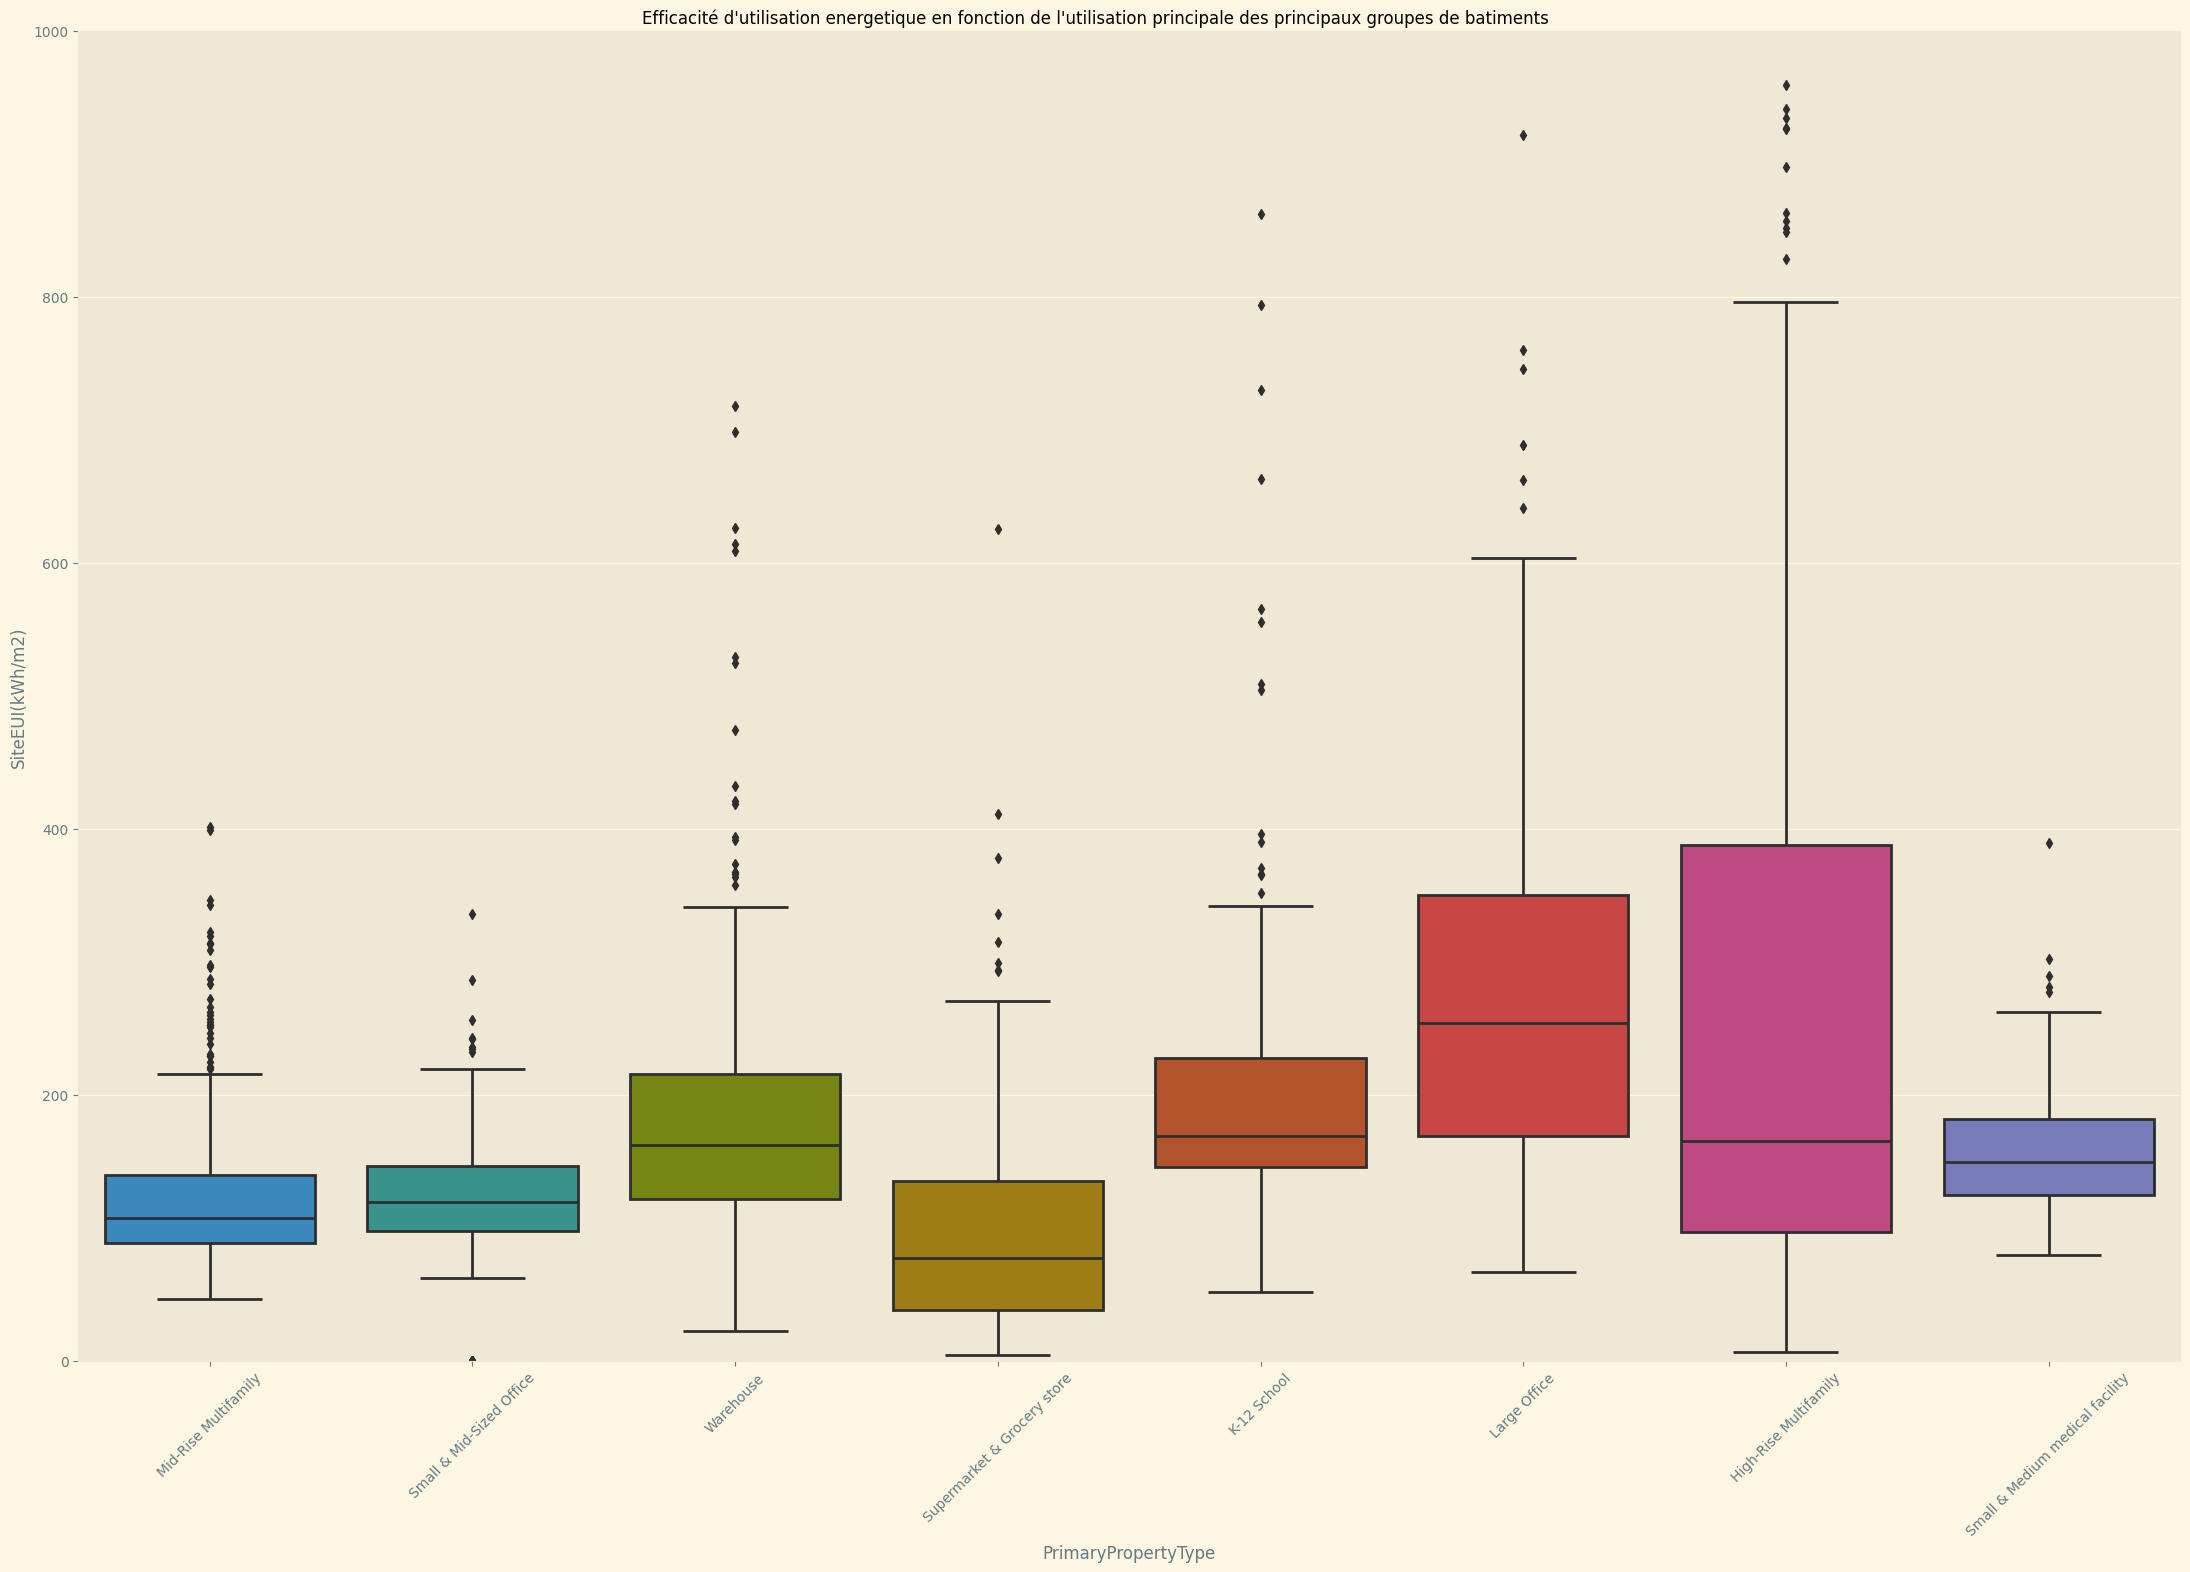

In [111]:
# EUI / E* , color code property type, sample based on smallest group size

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

data_ptype = df_sixteen[df_sixteen["PrimaryPropertyType"].isin(select_eight)]

ax1 = sns.boxplot(
    x=data_ptype["PrimaryPropertyType"],
    y=data_ptype["SiteEUI(kWh/m2)"],
    data=data_ptype
)

###
# Titles/Lables
ax1.set_xticklabels(
    labels=select_eight,
    rotation=45
    )
ax1.set_ylim(0, 1000)  # few outliers above
fig.suptitle("Efficacité d'utilisation energetique en fonction de l'utilisation principale des principaux groupes de batiments")

#
###

plt.tight_layout()
plt.show()


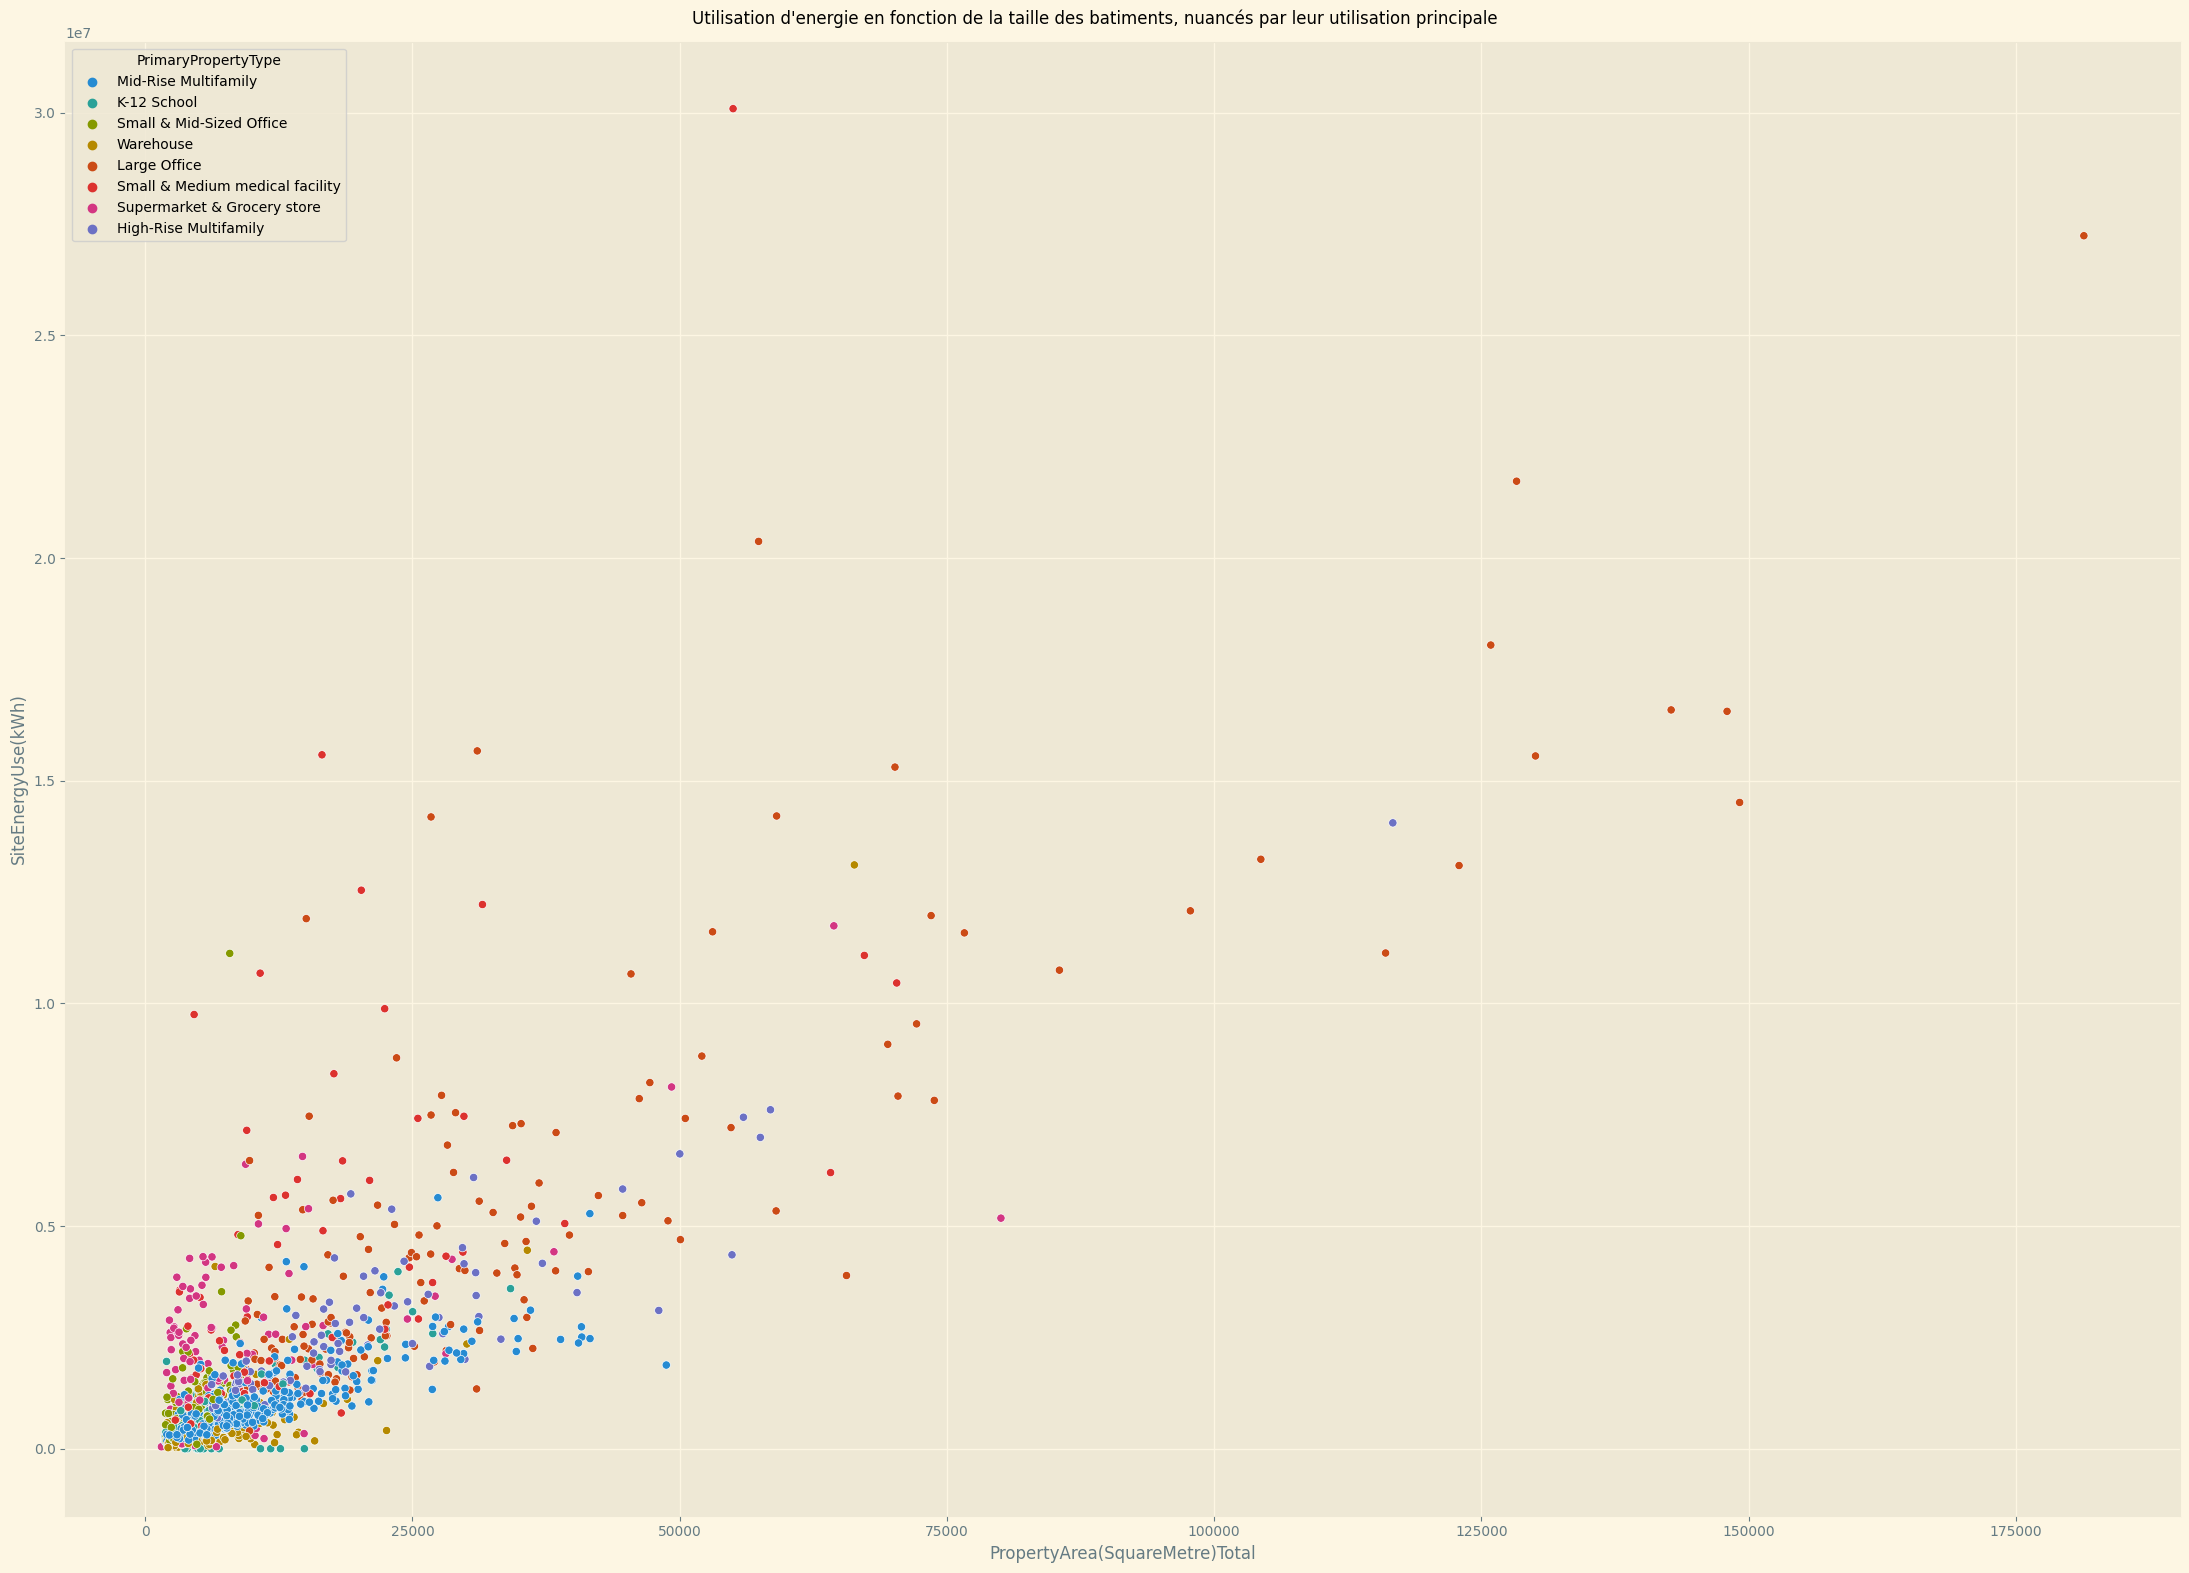

In [112]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 16),
    dpi=pc_dpi,
)

ax1 = sns.scatterplot(
    x="PropertyArea(SquareMetre)Total",
    y="SiteEnergyUse(kWh)",
    hue="PrimaryPropertyType",
    data=data_ptype
)

###
# Titles/Lables
fig.suptitle("Utilisation d'energie en fonction de la taille des batiments, nuancés par leur utilisation principale")
#
###

plt.tight_layout()
plt.show()


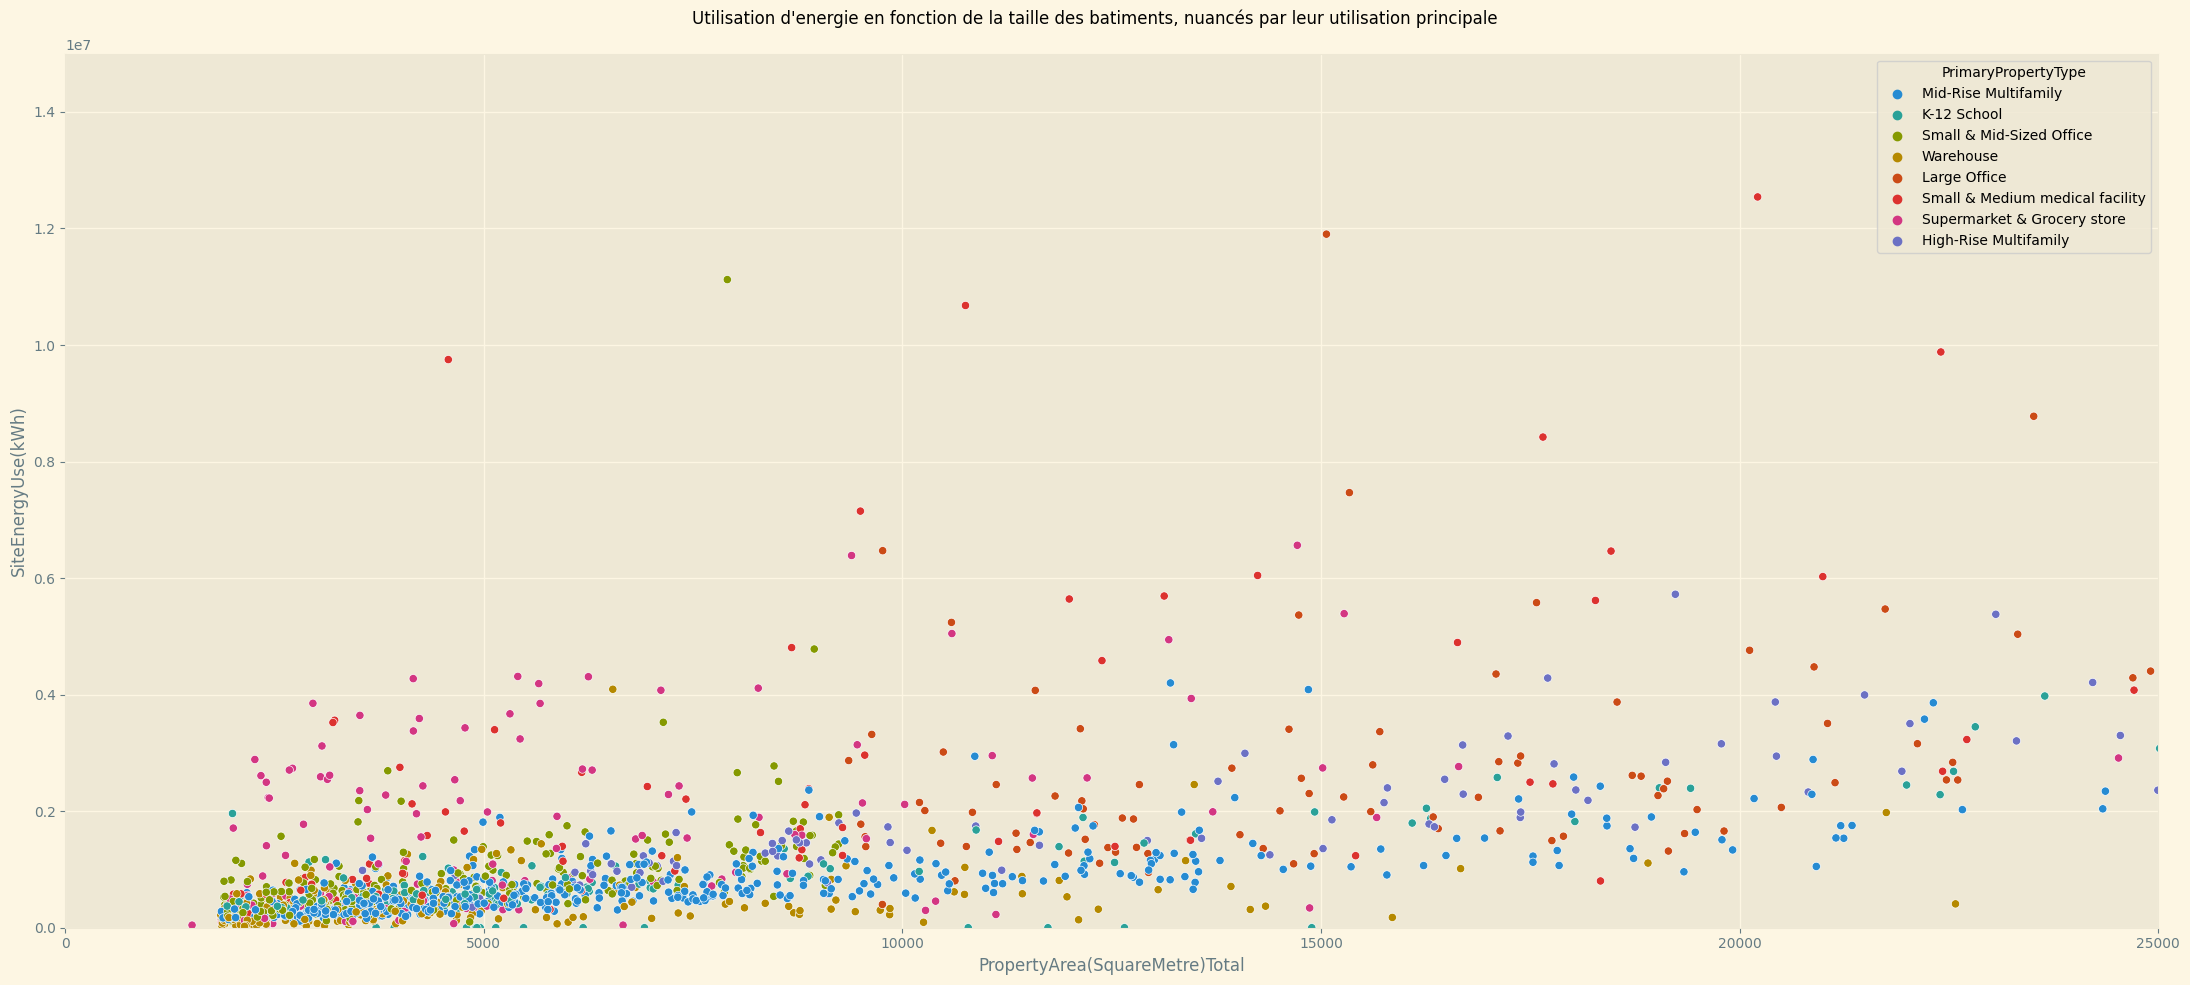

In [113]:
# Zooming on y=0.5 kWh/m2, x= 25km2

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.scatterplot(
    x="PropertyArea(SquareMetre)Total",
    y="SiteEnergyUse(kWh)",
    hue="PrimaryPropertyType",
    data=data_ptype
)


ax1.set_ylim(-100, 15000000)
ax1.set_xlim(0, 25000)

###
# Titles/Lables
fig.suptitle("Utilisation d'energie en fonction de la taille des batiments, nuancés par leur utilisation principale")
#
###

plt.tight_layout()
plt.show()


## Observation : On peut effectuer quelques remarques, malgré une apparence très groupée

- On distingue relativement facilement un groupe : Supermarket & Grocery Store (@ 2000-4000 MWh & 2.5-8 km2)
- Les batiments d'habitations (High rises et Mid Rises) semble obeir à une corrélation linéaire entre Zone totale et Utilisation d'Energie
- Medical Offices affiche une forte variance, sans doute causée par la présence, ou absence, d'équipement medical à forte utilisation d'energie (équipement variant majoritairement du fait de la spécialisation)
- Le boxplot montre que, si des batiments remplissent la meme fonction (dans le diagramme : high rise / mid rise = habitation, small/medium offices et large offices = Bureaux), l'efficacité d'utilisation energétique semble fortement augmenter avec la taille (denomination) du batiment, utilisation du Student's T-Test pour observer une correllation entre les deux paires étudiés
- On peut tenter d'effectuer un test ANOVA ou CHI2 pour identifier les corrélations si elles existent.


## Realisation de T-Tests (A) pour vérifier si l'augmentation de l'EUI est corrélée avec l'augmentation de la taille des batiments, ici : 
- Categories et hypothèses nulles :
    - High Rise vs Mid Rise : L'augmentation de l'EUI n'a rien à voir avec la difference de taille des batiments d'habitation
    - Small & Medium Office vs Large Office : L'augmentation de l'EUI n'a rien à voir avec la difference de taille d'immeubles de bureaux
- Les deux échantillons doivent être indépendants (ce qui est le cas)
- La variance inter echantillon doit être homogène (utilisation du test de Bartlett)
- Les résidus doivent suivre une distribution normale (ce qui sera vérifié en utilisant le test de Shapiro Wilks)
- On fixe alpha à 5%
- On cherche à rejeter les hypothèses nulles


In [114]:
alpha = 0.05


In [115]:
# High Rise / Mid Rise

high_rise_eui = df_sixteen[df_sixteen["PrimaryPropertyType"] == "High-Rise Multifamily"]["SiteEUI(kWh/m2)"]
mid_rise_eui = df_sixteen[df_sixteen["PrimaryPropertyType"] == "Mid-Rise Multifamily"]["SiteEUI(kWh/m2)"]

ttest_hab = stats.ttest_ind(a=high_rise_eui, b=mid_rise_eui)

print(ttest_hab, "\n", f"p-values < alpha : {ttest_hab.pvalue < alpha}")


Ttest_indResult(statistic=6.275185258472877, pvalue=6.478669134906195e-10) 
 p-values < alpha : True


In [116]:
# Null hypothesis : homoscedasticity

bartlett_test_hab = stats.bartlett(high_rise_eui, mid_rise_eui)

print(bartlett_test_hab, "\n", f"p-values > alpha : {bartlett_test_hab.pvalue > alpha}")


BartlettResult(statistic=0.06973953352929516, pvalue=0.7917163968929342) 
 p-values > alpha : True


### Analyse du t-test A.1 --> Batiments d'habitation : 
- Le test de Bartlett ne permet pas d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène, on accepte l'hypothèse nulle : les variances des echantillons sont homogènes
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = L'augmentation de l'EUI n'a rien à voir avec la difference de taille des batiments d'habitation, on accepte l'hypothèse alternative H1, à savoir : Dans le cas des immeubles d'habitations, l'augmentation de la taille cause une hausse de l'EUI (kWh/m2).
  

In [117]:
# Large Office / Small & Mid-Sized Office

large_office_eui = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Large Office") &
        (df_sixteen["SiteEUI(kWh/m2)"].notna())
    ]["SiteEUI(kWh/m2)"]

small_m_office_eui = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Small & Mid-Sized Office") &
        (df_sixteen["SiteEUI(kWh/m2)"].notna())
    ]["SiteEUI(kWh/m2)"]

ttest_office = stats.ttest_ind(a=small_m_office_eui, b=large_office_eui, equal_var=False)

print(ttest_office, "\n", f"p-values < alpha : {ttest_office.pvalue < alpha}")

Ttest_indResult(statistic=-1.6774630722273525, pvalue=0.09433925298045368) 
 p-values < alpha : False


In [118]:
# Null hypothesis : homoscedasticity

bartlett_test_office = stats.bartlett(large_office_eui, small_m_office_eui)

print(bartlett_test_office, "\n", f"p-values > alpha : {bartlett_test_office.pvalue > alpha}")


BartlettResult(statistic=0.4192116964390165, pvalue=0.5173306546961911) 
 p-values > alpha : True


### Analyse du t-test A.2 --> Immeubles de bureau :
- Le test de Bartlett ne permet pas d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène, on accepte l'hypothèse nulle : les variances des echantillons sont homogènes
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = L'augmentation de l'EUI n'a rien à voir avec la difference de taille des immeubles de bureau, on accepte l'hypothèse alternative H1, à savoir : Dans le cas des bureaux, l'augmentation de la taille cause une hausse de l'EUI (kWh/m2).


## Analyse :

- Ces deux tests confirment que l'éfficacité énergétique se déteriore, pour les batiments de meme type mais de tailles differentes
- Un modèle prenant en compte cette conclusion pourrait profiter d'une accélleration de performance dans la prediction de l'éfficacité energetique d'un batiment
- Une première analyse effectuee plus haut ne permettait pas de corréler la note E* à la taille des batiments. Il peut etre interessant de voir si le type de batiment n'a egalement pas, visiblement, d'influence sur la note E* :
  - Si corrélation : Meilleure comprehension de la note.
  - Sinon : Note basée sur d'autres facteurs / comprehensive de l'observation ci dessus.

In [119]:
hab_off = ["Mid-Rise Multifamily", "High-Rise Multifamily", "Small & Mid-Sized Office", "Large Office"]


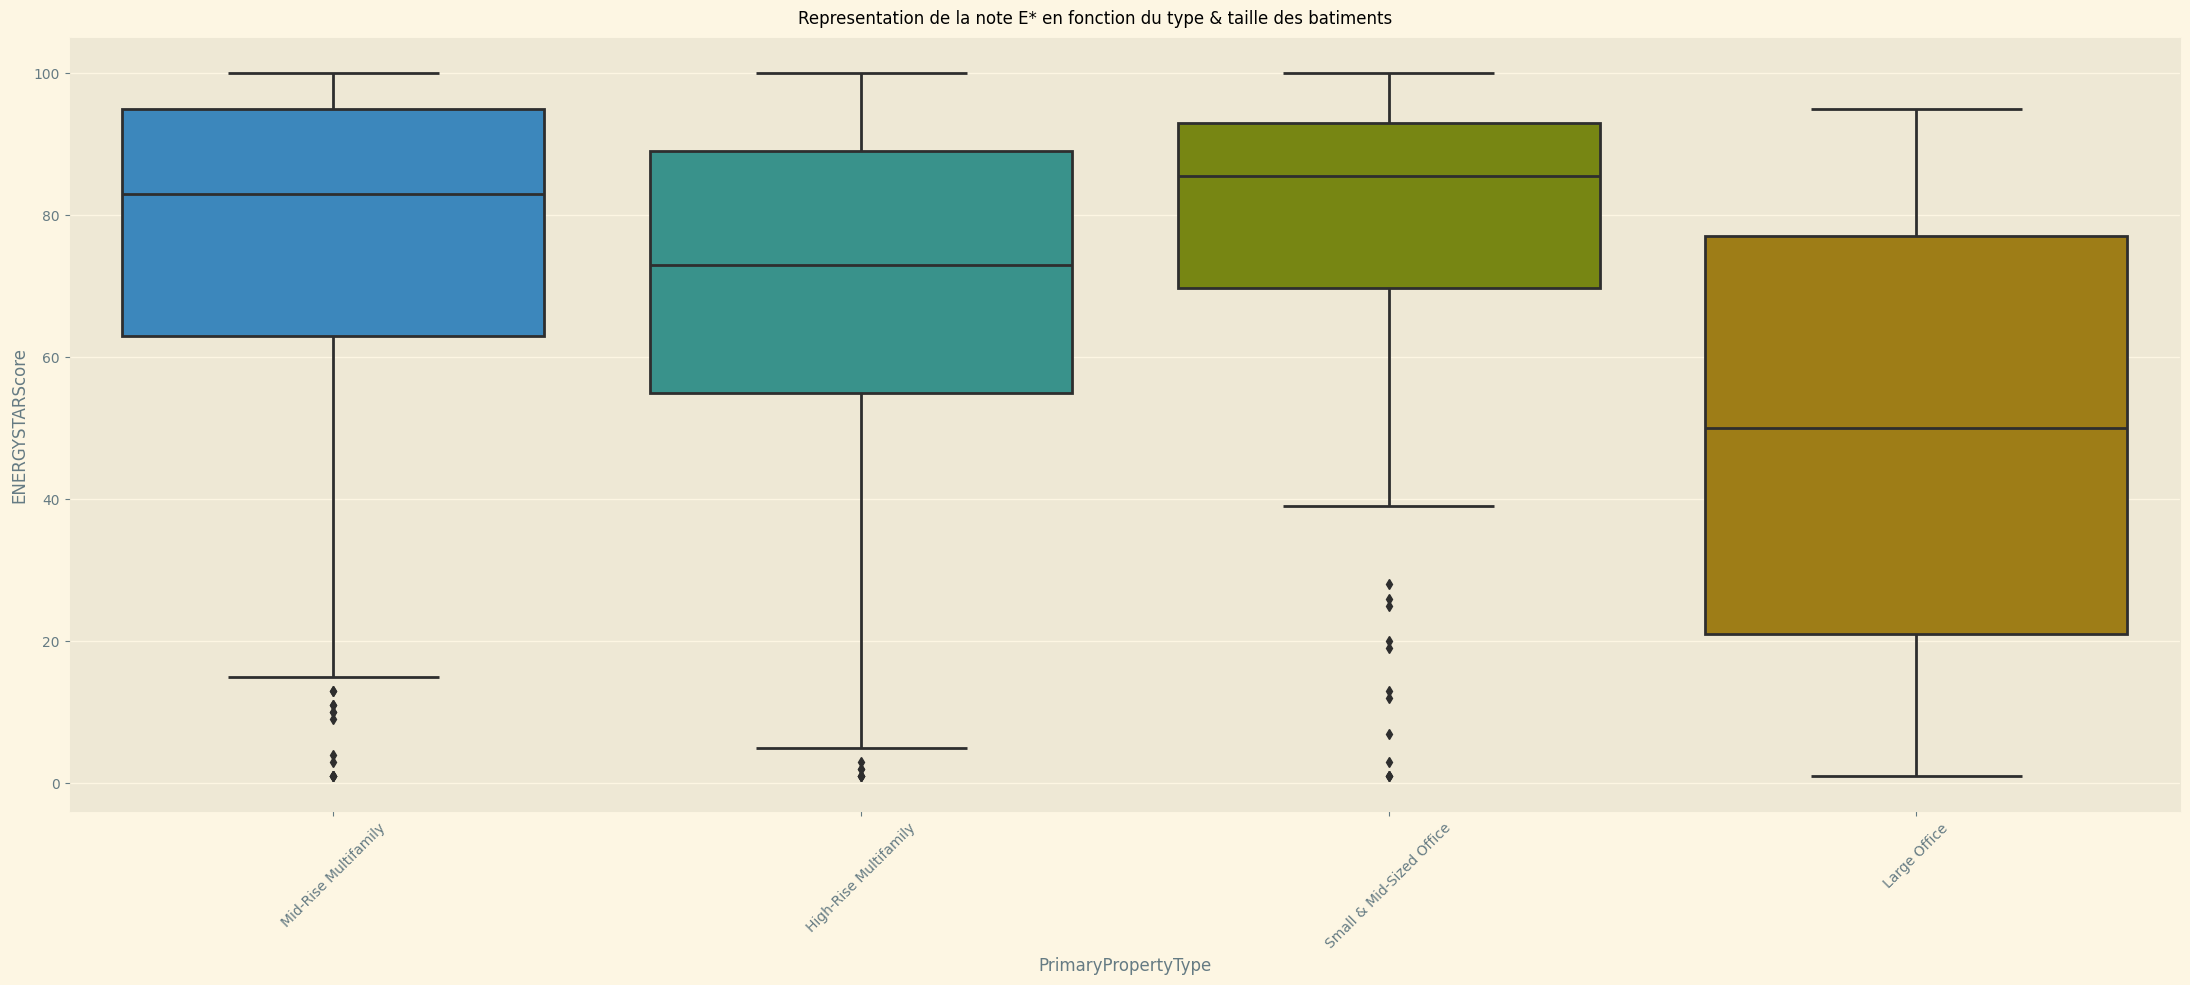

In [120]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

data_es_ptype = df_sixteen[
    (df_sixteen["PrimaryPropertyType"].isin(hab_off)) &
    (df_sixteen["ENERGYSTARScore"].notna()) &
    (df_sixteen["SiteEUI(kWh/m2)"].notna())
    ]

ax1 = sns.boxplot(
        x=data_es_ptype["PrimaryPropertyType"],
        y=data_es_ptype["ENERGYSTARScore"].astype(int),
        data=data_es_ptype
    )


###
# Titles/Lables
ax1.set_xticklabels(
    labels=hab_off,
    rotation=45
    )
fig.suptitle("Representation de la note E* en fonction du type & taille des batiments")
#
###

fig.tight_layout()
plt.show()


## Observations :
- La meme tendance observee dans l'analyse de l'EUI par type de batiment semble etre egalement presente dans ce cas
- La variance semble similaire dans le cas des batiments d'habitation, le cas des immeubles du bureau montre une variance largement superieure dans le cas des plus grands batiments
- On peut effectuer les memes series de tests que dans le cas de l'EUI, meme si le critere d'homoscédasticité semble invalide dans le cas des bureaux

## Realisation de T-Tests pour vérifier si la baisse de la note E* est corrélée avec l'augmentation de la taille des batiments, ici : 
- Categories et hypothèses nulles :
    - High Rise vs Mid Rise : Le baisse globale des notes n'est pas corrélée avec la taille des batiments d'habitation. 
    - Small & Medium Office vs Large Office : Le baisse globale des notes n'est pas corrélée avec la taille des bureaux. 
- Les deux échantillons doivent être indépendants (ce qui est le cas)
- La variance inter echantillon doit être homogène (utilisation du test de Bartlett)
- Les résidus doivent suivre une distribution normale (ce qui sera vérifié en utilisant le test de Shapiro Wilks)
- On fixe alpha à 5%
- On cherche à rejeter les hypothèses nulles


In [121]:
# High Rise / Mid Rise

high_rise_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "High-Rise Multifamily") &
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)

mid_rise_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Mid-Rise Multifamily") & 
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)


In [122]:
# Null hypothesis : homoscedasticity

bartlett_test_estar_hab = stats.bartlett(high_rise_estar, mid_rise_estar)

print(bartlett_test_estar_hab, "\n", f"p-values > alpha : {bartlett_test_estar_hab.pvalue > alpha}")


BartlettResult(statistic=6.282718931350869, pvalue=0.012192090215447279) 
 p-values > alpha : False


In [123]:
# Std not equal with alpha @5%, using ttest ind with parameter : equal_var = False

ttest_estar_hab = stats.ttest_ind(a=high_rise_estar, b=mid_rise_estar, equal_var=False)

print(ttest_estar_hab, "\n", f"p-values < alpha : {ttest_estar_hab.pvalue < alpha}")


Ttest_indResult(statistic=-7.712702193165108, pvalue=5.136785418294132e-12) 
 p-values < alpha : True


### Analyse du t-test B.1 --> Batiments d'habitation : 
- Le test de Bartlett permet d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène. Les parametres du t-test sont ajustés pour refleter cela : equal_var = False
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = Le baisse globale des notes n'est pas corrélée avec la taille des batiments d'habitation. On accepte l'hypothèse alternative H1, à savoir : Il existe une corrélation négative entre la taille d'un batiment d'habitation et sa note E*

In [124]:
# Large Office / Small & Mid-Sized Office

large_off_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Large Office") &
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)

small_med_off_estar = df_sixteen[
        (df_sixteen["PrimaryPropertyType"] == "Small & Mid-Sized Office") & 
        (df_sixteen["ENERGYSTARScore"].notna())
    ]["ENERGYSTARScore"].astype(int)


In [125]:
# Null hypothesis : homoscedasticity

bartlett_test_estar_off = stats.bartlett(large_off_estar, small_med_off_estar)

print(bartlett_test_estar_off, "\n", f"p-values > alpha : {bartlett_test_estar_off.pvalue > alpha}")


BartlettResult(statistic=2.525595099996447, pvalue=0.11201251551454779) 
 p-values > alpha : True


In [126]:
# Std equal with alpha @5%, using ttest ind with parameter : equal_var = True

ttest_estar_off = stats.ttest_ind(a=large_off_estar, b=small_med_off_estar, equal_var=True)

print(ttest_estar_off, "\n", f"p-values < alpha : {ttest_estar_off.pvalue < alpha}")


Ttest_indResult(statistic=3.601250720372755, pvalue=0.00035758584241275414) 
 p-values < alpha : True


### Analyse du t-test B.2 --> Batiments d'habitation : 
- Le test de Bartlett ne permet pas d'accepter l'hypothèse alternative telle que : la variance inter echantillon n'est pas homogène. On accepte l'hypothèse alternative : Les variances sont homogènes.
- Le test de Student / t-test permet de refuter l'hypothèse nulle telle que : H0 = Le baisse globale des notes n'est pas corrélée avec la taille des bureaux. On accepte l'hypothèse alternative H1, à savoir : Il existe une corrélation négative entre la taille d'un immeuble de bureau et sa note E*

## Conclusions A & B : :Valable seulement dans les categories des bureaux et des habitations:
- On peut constater, dans le cas des batiments d'habitation et des bureaux, une corréllation, a la fois positive vis à vis de l'EUI (+ = moins efficace) & négative dans le cas de la note E*
- La note E* n'est pas comprehensive de la taille d'un batiment
- On peut conclure que la note E* est bien plus influencée par l'efficacité energétique d'un batiment que par sa taille. Plus un batiment est grand, plus on peut s'attendre a une augmentation de la consommation electrique horaire par metre carré, et donc une influence négative sur sa note E*

# Reduction de dimension pour approche orientée objet

## Approche OOP

Une approche orienté objet à pour avantage de définir clairement, non seulement un batiment, mais egalement les categories a laquelle il appartient. <br>
Nous pourrons traiter facilement un type de batiment en tant qu'objet, tous les batiments heritant de la  `class type`  etc. De plus, il sera plus simple d'appliquer des methodes d'instances ou de classe. <br>
Une reduction de dimension permettrait egalement de definir un batiment suivant la date des donnees (2015 et 2016) plus facilement qu'en comparant deux datasets comptant de nombreuses variables.

## Necessité de reduction de dimension

Pour rendre lisible et faisable cette approche, il est necessaire de reduire la dimension du dataset pour que le moins d'attributs/propriétées possibles puissent fournir le maximum d'information.
- Dans un premier temps, il est envisageable de realiser une reduction de dimension sur les variables, si possible via ACP (si cette approche se révèle trop peu precise, les methodes non lineaires telles que T-SNE ou UMAP sont envisageables)
- Dans un second temps, l'étude ci dessus a pu montrer que les batiments appartenant aux memes "categories" partagent des caracteristiques et des trends qui peuvent etre exploitables pour traiter les objets en tant que clusters plutot que separement (K-Means)


## 0. Fusion des dataframes & Suppression des batiments residentiels: 

- Il est inutile de d'utiliser les deux datasets, une comparaison 2015/2016 avec seulement deux données n'est pas fiable
- Les batiments non communs aux deux datasets ne seront pas admis (?)
- Les données les plus actuelles (2016) seront utilisées par defaut, si une donnée est manquante, on cherchera dans le df2015, si presente dans 2015, on mettra à jour le df
- Les batiments seront identifisé par leur OSE ID
- L'étude n'a plus besoin des batiments residentiels, ils seront supprimés

In [127]:
df_sixteen["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)'], dtype=object)

In [128]:
residential = ["Multifamily MR (5-9)", "Multifamily LR (1-4)", "Multifamily HR (10+)"]


In [129]:
# complete_df(df_one=df_sixteen, df_two=df_fifteen, on_col="OSEBuildingID")  NOT WORKING YET

df_seattle = df_sixteen[~df_sixteen["BuildingType"].isin(residential)]


In [130]:
df_seattle["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

## 1. Reduction de dimension via ACP

In [131]:
exclude_pca = [
        "OSEBuildingID", "BuildingType", "PrimaryPropertyType", "PropertyName",
        "Neighborhood", "YearBuilt", "ListOfAllPropertyUseTypes", "LargestPropertyUseType",
        "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "ENERGYSTARScore",  # E* Excluded -> baseline
        "DefaultData","ComplianceStatus"
    ]

columns_pca = [col for col in df_seattle.columns if col not in exclude_pca]

columns_pca


['NumberofBuildings',
 'NumberofFloors',
 'Electricity(kWh)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'PropertyArea(SquareMetre)Total',
 'PropertyArea(SquareMetre)Parking',
 'PropertyArea(SquareMetre)Building(s)',
 'LargestPropertyUseTypeArea(SquareMetre)',
 'SecondLargestPropertyUseTypeArea(SquareMetre)',
 'ThirdLargestPropertyUseTypeArea(SquareMetre)',
 'SiteEUI(kWh/m2)',
 'SiteEUIWN(kWh/m2)',
 'SourceEUI(kWh/m2)',
 'SourceEUIWN(kWh/m2)',
 'SiteEnergyUse(kWh)',
 'SiteEnergyUseWN(kWh)',
 'SteamUse(kWh)',
 'NaturalGas(kWh)']

In [132]:
data_pca = df_seattle[columns_pca]

data_pca = data_pca.astype(float)  # All values are forced converted to float, as the columns above (columns_pca) are all numeric

data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = df_seattle.index
features = columns_pca

scaled_data = preprocessing.scale(data_pca)
pca = PCA(n_components=len(columns_pca))
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
percentage_variation = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

pcs = pca.components_


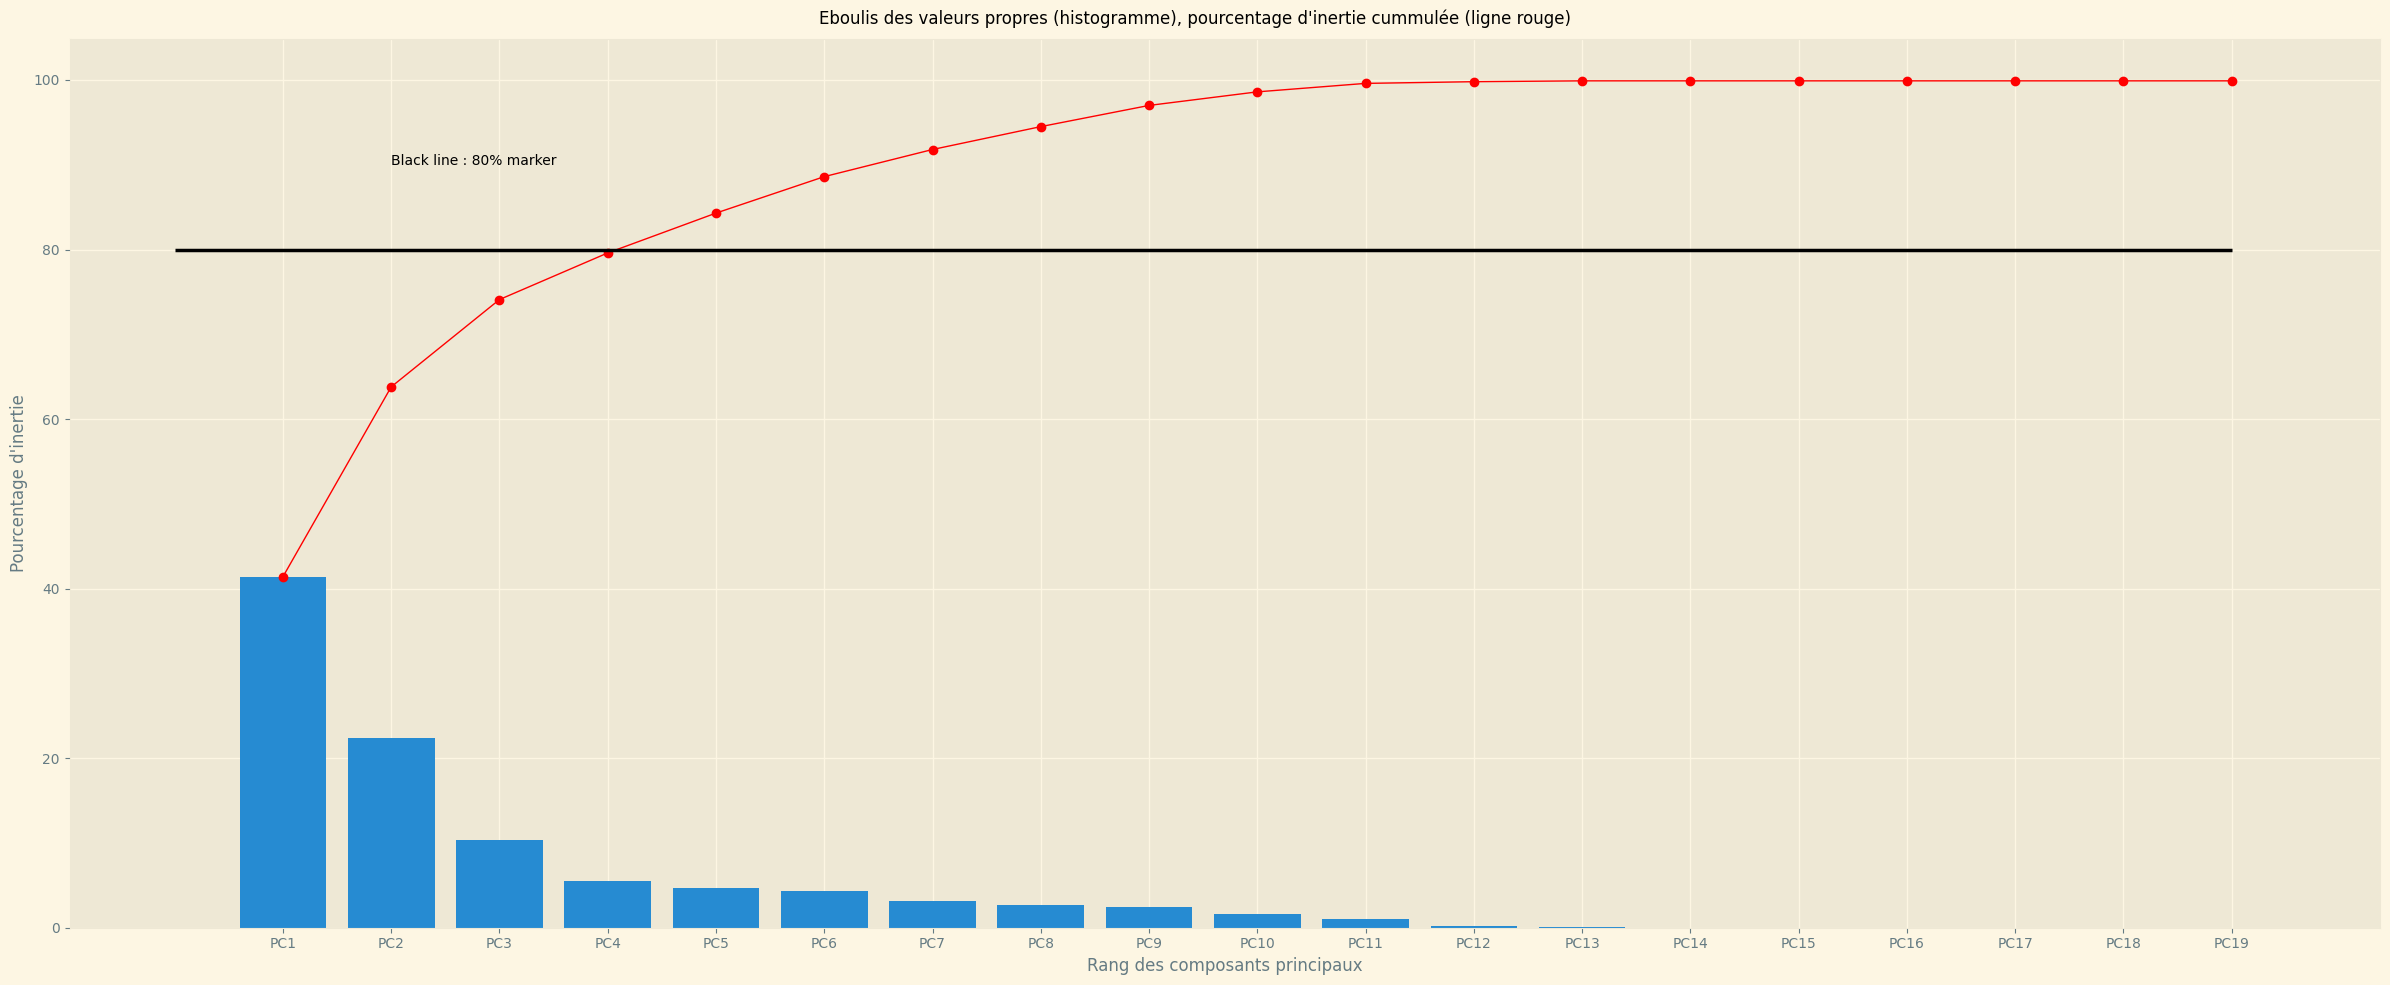

In [133]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(24, 10),
    dpi=pc_dpi,
)

x_bars = np.arange(1, len(percentage_variation) + 1, 1)

cummulative_percentage = np.cumsum(percentage_variation)

ax1.bar(x_bars, height=percentage_variation)  # Inertia Scree

###
# Titles/Lables
labels = ["PC" + str(c) for c in range (1, len(percentage_variation) + 1)]
ax1.set_xticks(range(1, len(labels) + 1, 1))
ax1.set_xticklabels(labels)
ax1.set_xlabel("Rang des composants principaux")
ax1.set_ylabel("Pourcentage d'inertie")
fig.suptitle("Eboulis des valeurs propres (histogramme), pourcentage d'inertie cummulée (ligne rouge)")
ax1.text(2,90,'Black line : 80% marker')
#
###

ax1.plot(ax1.get_xticks(), cummulative_percentage, marker="o", color="r", linewidth=1)  # Cumulative Inertia
ax1.plot(np.arange(0, len(cummulative_percentage) + 1, 1), [80 for _ in range(0, len(cummulative_percentage) + 1)], color="0", linewidth=2.5)
fig.tight_layout()

plt.show()


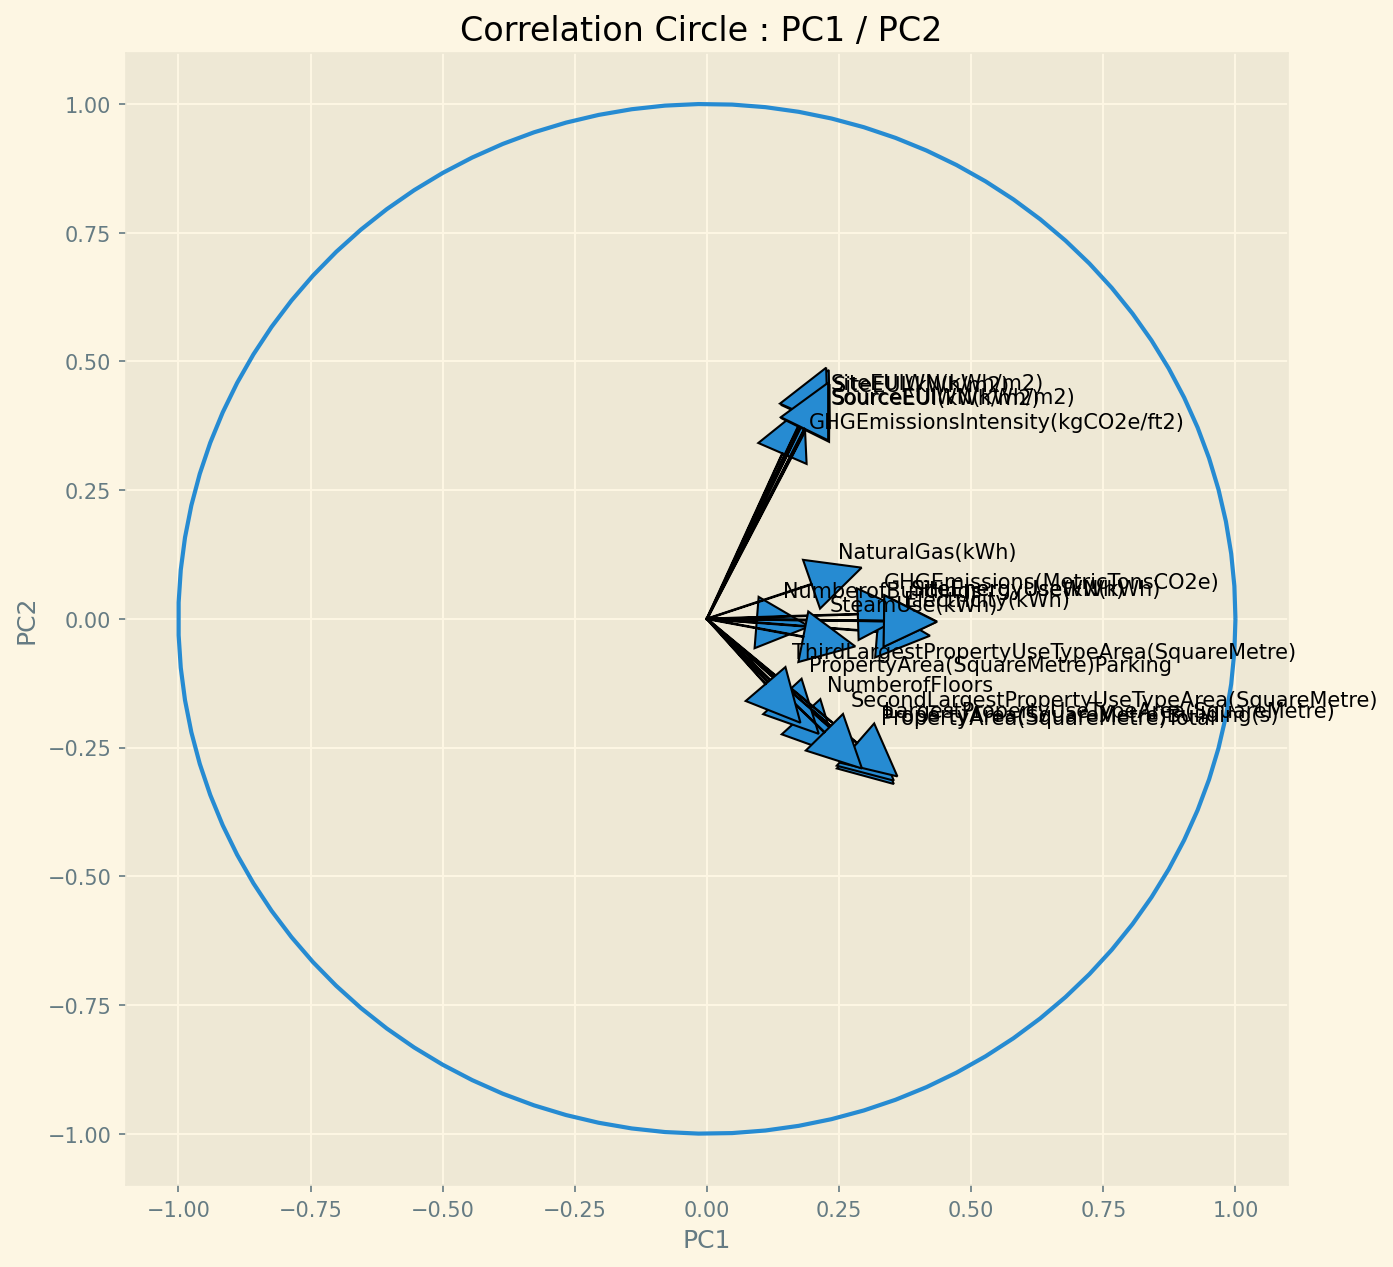

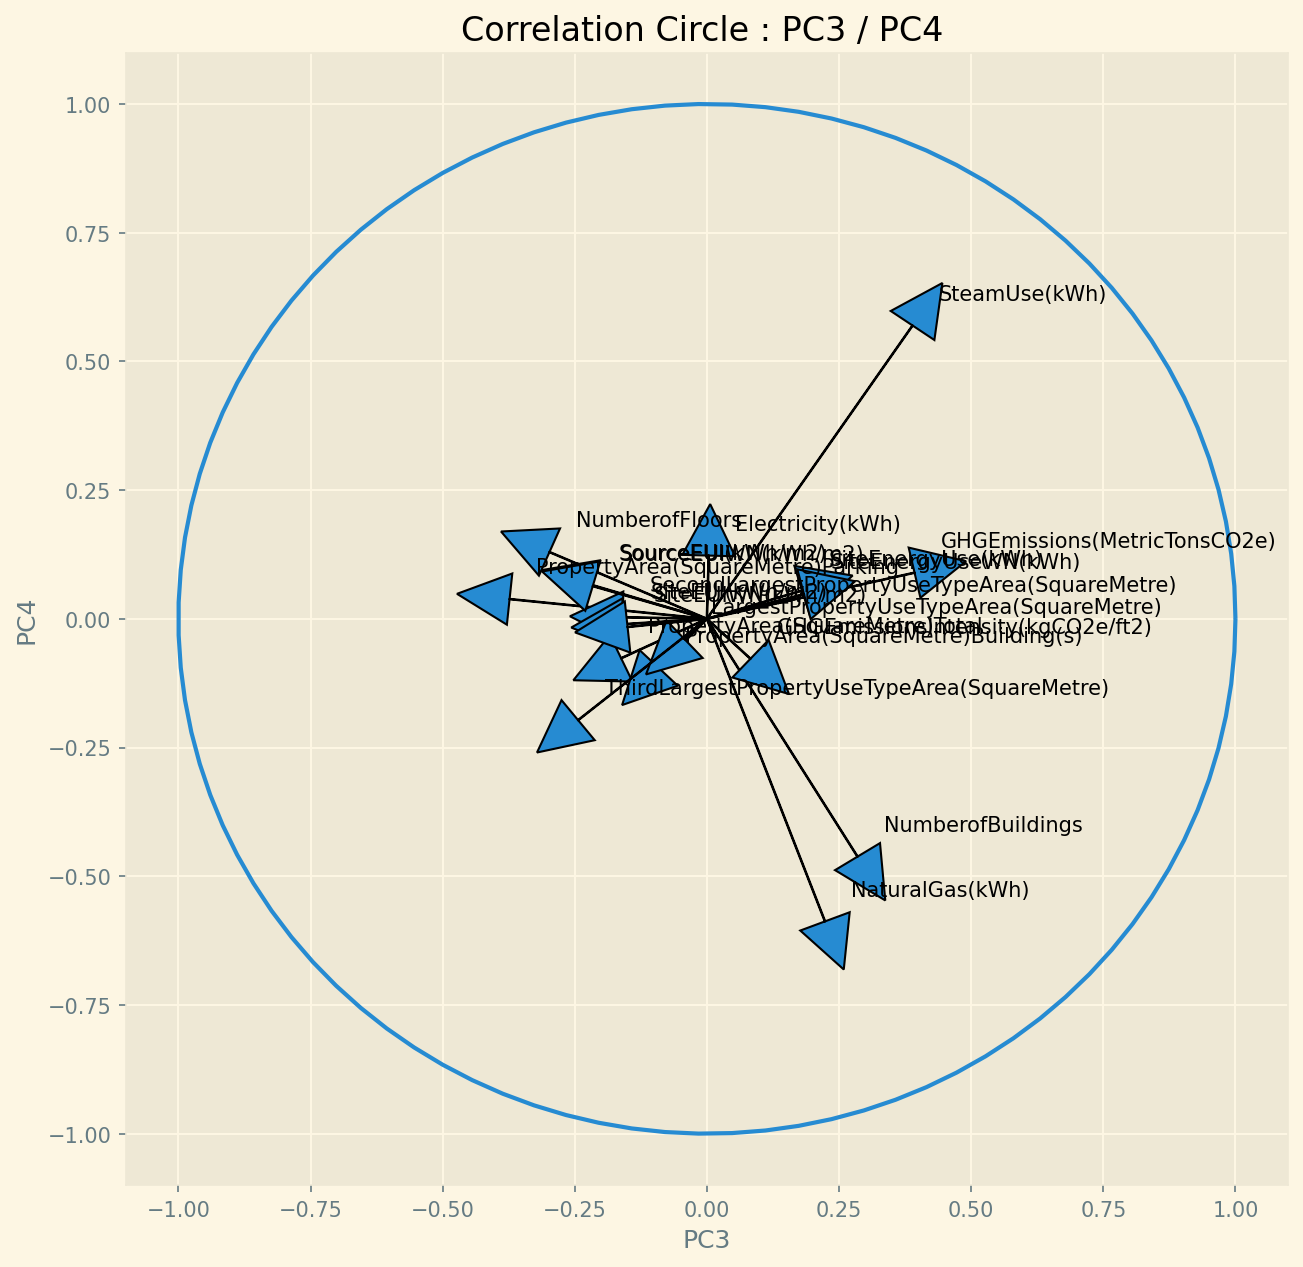

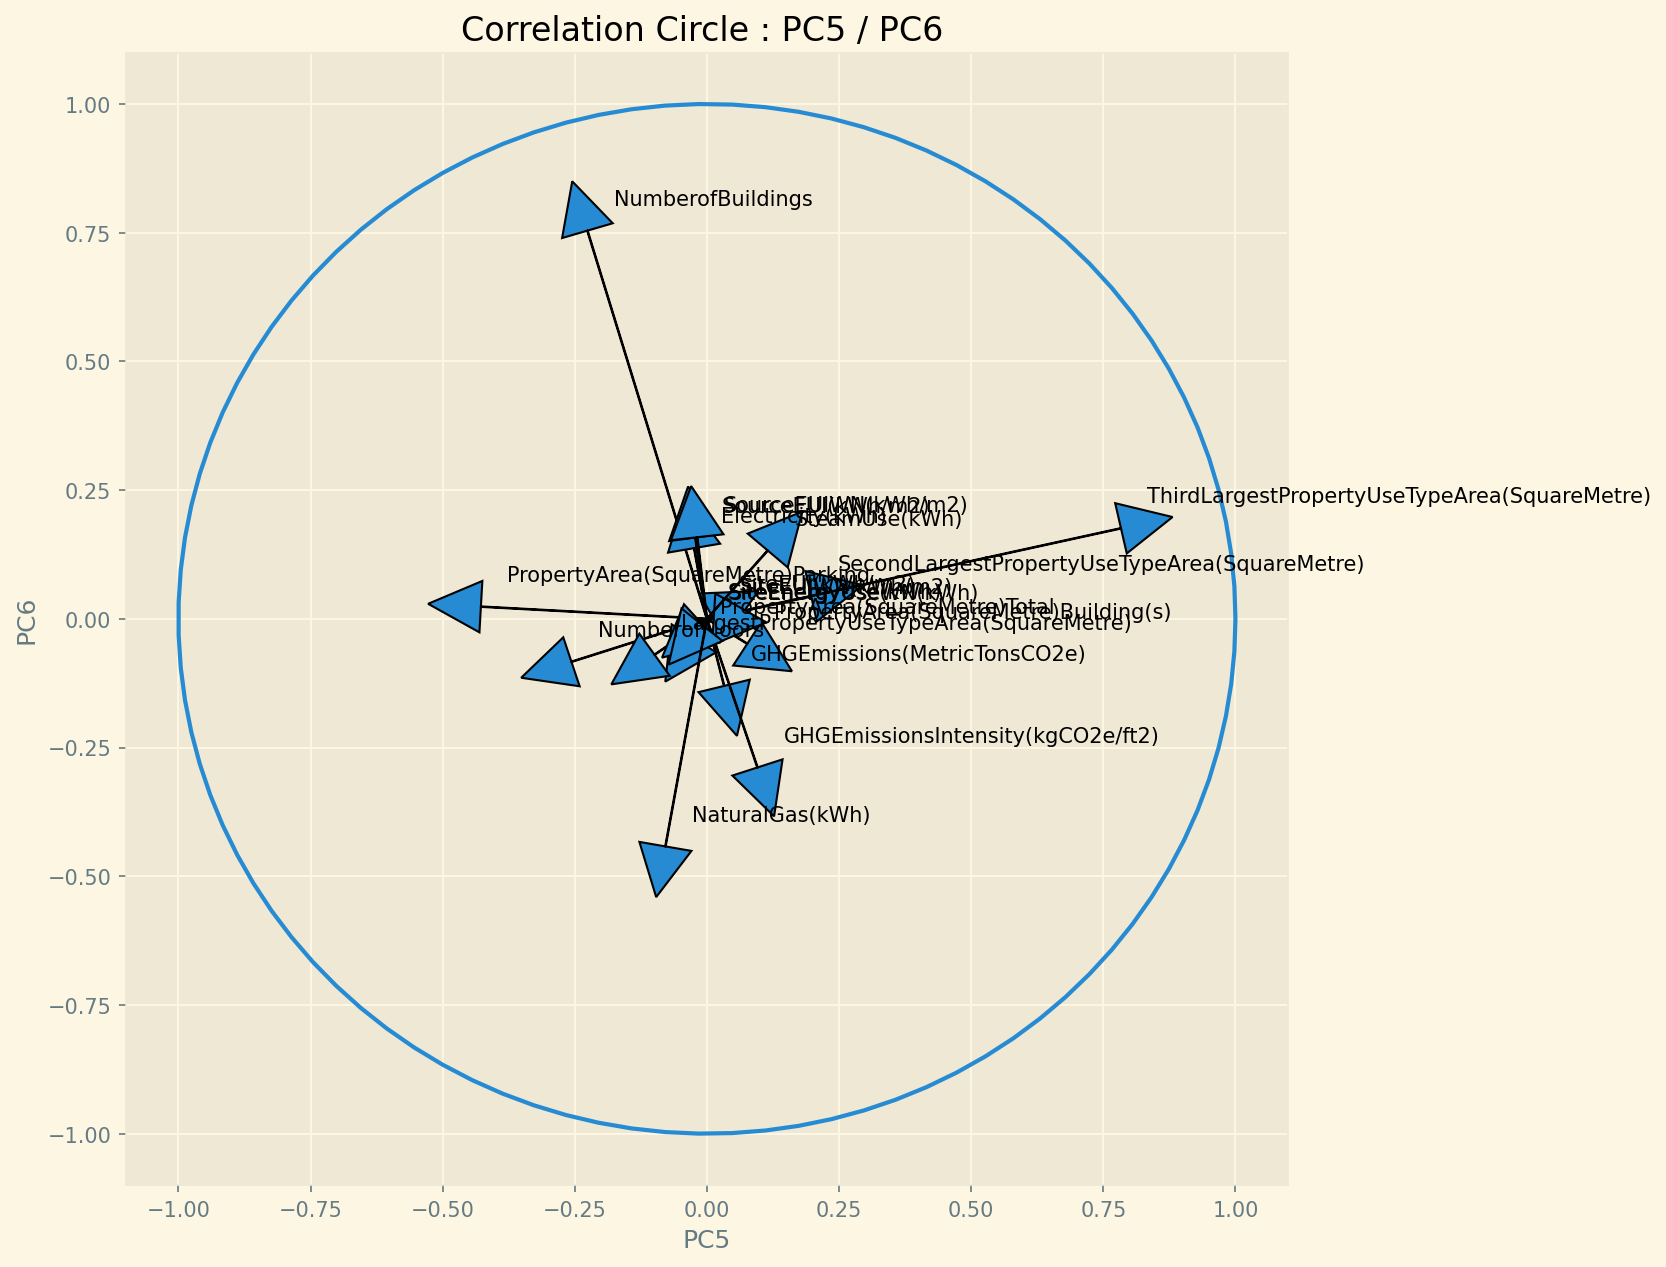

In [134]:
couples = [(0, 1), (2, 3), (4, 5)]

for couple in couples:
    display_circles(pca=pca, pca_cols=columns_pca, couple_pc=couple)

In [135]:
pca_explained_df = show_contribution(pca=pca, columns_pca=columns_pca, lim_pc=5)
pca_explained_df


,PC1,PC2,PC3,PC4,PC5
NumberofBuildings,0.094043,-0.007240,0.284971,-0.461859,-0.226076
NumberofFloors,0.178087,-0.190140,-0.297853,0.129702,-0.256279
Electricity(kWh),0.322236,-0.025074,0.003425,0.122883,-0.024193
GHGEmissions(MetricTonsCO2e),0.285470,0.009056,0.392855,0.089616,0.032598
GHGEmissionsIntensity(kgCO2e/ft2),0.142933,0.321233,0.082420,-0.077528,0.095670
PropertyArea(SquareMetre)Total,0.279538,-0.253599,-0.162252,-0.076611,-0.024529
PropertyArea(SquareMetre)Parking,0.142778,-0.150782,-0.373331,0.038345,-0.427613
PropertyArea(SquareMetre)Building(s),0.278916,-0.247867,-0.091281,-0.095274,0.076432
LargestPropertyUseTypeArea(SquareMetre),0.284148,-0.241322,-0.042241,-0.039579,-0.099063
SecondLargestPropertyUseTypeArea(SquareMetre),0.222309,-0.220284,-0.159125,0.003038,0.197224


In [136]:
pca_explained_df["PC1"].sort_values(ascending=False)
# Likely raw energy use and GHG emissions

contribution                                     41.400000
SiteEnergyUse(kWh)                                0.335271
SiteEnergyUseWN(kWh)                              0.335020
Electricity(kWh)                                  0.322236
GHGEmissions(MetricTonsCO2e)                      0.285470
LargestPropertyUseTypeArea(SquareMetre)           0.284148
PropertyArea(SquareMetre)Total                    0.279538
PropertyArea(SquareMetre)Building(s)              0.278916
SecondLargestPropertyUseTypeArea(SquareMetre)     0.222309
NaturalGas(kWh)                                   0.197967
SiteEUI(kWh/m2)                                   0.187452
SourceEUI(kWh/m2)                                 0.186531
SourceEUIWN(kWh/m2)                               0.184668
SiteEUIWN(kWh/m2)                                 0.183660
SteamUse(kWh)                                     0.182426
NumberofFloors                                    0.178087
GHGEmissionsIntensity(kgCO2e/ft2)                 0.1429

In [137]:
pca_explained_df["PC2"].sort_values(ascending=False)
# Likely EUI + / Size -  ==> EUI (energy/size)


contribution                                     22.400000
SiteEUIWN(kWh/m2)                                 0.397056
SiteEUI(kWh/m2)                                   0.393077
SourceEUIWN(kWh/m2)                               0.369244
SourceEUI(kWh/m2)                                 0.366526
GHGEmissionsIntensity(kgCO2e/ft2)                 0.321233
NaturalGas(kWh)                                   0.067242
GHGEmissions(MetricTonsCO2e)                      0.009056
SiteEnergyUse(kWh)                               -0.004051
SiteEnergyUseWN(kWh)                             -0.004465
NumberofBuildings                                -0.007240
Electricity(kWh)                                 -0.025074
SteamUse(kWh)                                    -0.034806
ThirdLargestPropertyUseTypeArea(SquareMetre)     -0.126613
PropertyArea(SquareMetre)Parking                 -0.150782
NumberofFloors                                   -0.190140
SecondLargestPropertyUseTypeArea(SquareMetre)    -0.2202

In [138]:
pca_explained_df["PC3"].sort_values(ascending=False)


contribution                                     10.300000
GHGEmissions(MetricTonsCO2e)                      0.392855
SteamUse(kWh)                                     0.389095
NumberofBuildings                                 0.284971
NaturalGas(kWh)                                   0.223401
SiteEnergyUseWN(kWh)                              0.183700
SiteEnergyUse(kWh)                                0.180063
GHGEmissionsIntensity(kgCO2e/ft2)                 0.082420
Electricity(kWh)                                  0.003425
LargestPropertyUseTypeArea(SquareMetre)          -0.042241
PropertyArea(SquareMetre)Building(s)             -0.091281
SiteEUIWN(kWh/m2)                                -0.150107
SiteEUI(kWh/m2)                                  -0.156846
SecondLargestPropertyUseTypeArea(SquareMetre)    -0.159125
PropertyArea(SquareMetre)Total                   -0.162252
SourceEUIWN(kWh/m2)                              -0.215939
SourceEUI(kWh/m2)                                -0.2172

In [139]:
pca_explained_df["PC4"].sort_values(ascending=False)


contribution                                     5.500000
SteamUse(kWh)                                    0.569744
NumberofFloors                                   0.129702
Electricity(kWh)                                 0.122883
GHGEmissions(MetricTonsCO2e)                     0.089616
SourceEUI(kWh/m2)                                0.065658
SourceEUIWN(kWh/m2)                              0.063646
SiteEnergyUse(kWh)                               0.054897
SiteEnergyUseWN(kWh)                             0.047801
PropertyArea(SquareMetre)Parking                 0.038345
SecondLargestPropertyUseTypeArea(SquareMetre)    0.003038
SiteEUI(kWh/m2)                                 -0.010330
SiteEUIWN(kWh/m2)                               -0.015852
LargestPropertyUseTypeArea(SquareMetre)         -0.039579
PropertyArea(SquareMetre)Total                  -0.076611
GHGEmissionsIntensity(kgCO2e/ft2)               -0.077528
PropertyArea(SquareMetre)Building(s)            -0.095274
ThirdLargestPr

In [140]:
pca_explained_df["PC5"].sort_values(ascending=False)


contribution                                     4.700000
ThirdLargestPropertyUseTypeArea(SquareMetre)     0.783417
SecondLargestPropertyUseTypeArea(SquareMetre)    0.197224
SteamUse(kWh)                                    0.115042
GHGEmissionsIntensity(kgCO2e/ft2)                0.095670
PropertyArea(SquareMetre)Building(s)             0.076432
GHGEmissions(MetricTonsCO2e)                     0.032598
SiteEUIWN(kWh/m2)                                0.012824
SiteEUI(kWh/m2)                                  0.009843
SiteEnergyUseWN(kWh)                            -0.009333
SiteEnergyUse(kWh)                              -0.010137
SourceEUIWN(kWh/m2)                             -0.018309
SourceEUI(kWh/m2)                               -0.021889
Electricity(kWh)                                -0.024193
PropertyArea(SquareMetre)Total                  -0.024529
NaturalGas(kWh)                                 -0.078490
LargestPropertyUseTypeArea(SquareMetre)         -0.099063
NumberofBuildi

### Observations : 

- Trop de variables ont été passés au PCA, le resultat est confus
- Difficile de definir clairement les composants principaux

<hr>

- Une ACP sur moins de variables serait sans doute plus efficace
- Determination des variables contenant le plus de valeurs manquantes et recreation du PCA

In [141]:
nans_cols_pca = dict.fromkeys(columns_pca)

total_buildings = len(df_seattle)

for col in nans_cols_pca.keys():
    nans_cols_pca[col] = f"{(df_seattle[col].isna().sum() / total_buildings) * 100}%"
    print(col, "=", nans_cols_pca[col])


NumberofBuildings = 0.12468827930174563%
NumberofFloors = 0.0%
Electricity(kWh) = 0.12468827930174563%
GHGEmissions(MetricTonsCO2e) = 0.12468827930174563%
GHGEmissionsIntensity(kgCO2e/ft2) = 0.12468827930174563%
PropertyArea(SquareMetre)Total = 0.0%
PropertyArea(SquareMetre)Parking = 0.0%
PropertyArea(SquareMetre)Building(s) = 0.0%
LargestPropertyUseTypeArea(SquareMetre) = 0.3117206982543641%
SecondLargestPropertyUseTypeArea(SquareMetre) = 48.44139650872818%
ThirdLargestPropertyUseTypeArea(SquareMetre) = 78.92768079800499%
SiteEUI(kWh/m2) = 0.18703241895261846%
SiteEUIWN(kWh/m2) = 0.18703241895261846%
SourceEUI(kWh/m2) = 0.12468827930174563%
SourceEUIWN(kWh/m2) = 0.12468827930174563%
SiteEnergyUse(kWh) = 0.12468827930174563%
SiteEnergyUseWN(kWh) = 0.18703241895261846%
SteamUse(kWh) = 0.12468827930174563%
NaturalGas(kWh) = 0.12468827930174563%


In [142]:
to_remove = [
    "SecondLargestPropertyUseTypeArea(SquareMetre)",
    "ThirdLargestPropertyUseTypeArea(SquareMetre)",
    "LargestPropertyUseTypeArea(SquareMetre)",
    "NumberofBuildings",
    "NumberofFloors",
    ]

for col in columns_pca:
    if col in to_remove:
        columns_pca.remove(col)

# By nan and repetition


In [143]:
# EPA has determined that source energy is the most equitable [...] cf. sources
[columns_pca.remove(col) for col in columns_pca if col.lower().startswith("site")]
[columns_pca.remove(col) for col in columns_pca if col.lower().startswith("site")]  # hi bob
# |^| needs two passes, no idea why

columns_pca

['NumberofFloors',
 'Electricity(kWh)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'PropertyArea(SquareMetre)Total',
 'PropertyArea(SquareMetre)Parking',
 'PropertyArea(SquareMetre)Building(s)',
 'SecondLargestPropertyUseTypeArea(SquareMetre)',
 'SourceEUI(kWh/m2)',
 'SourceEUIWN(kWh/m2)',
 'SteamUse(kWh)',
 'NaturalGas(kWh)']

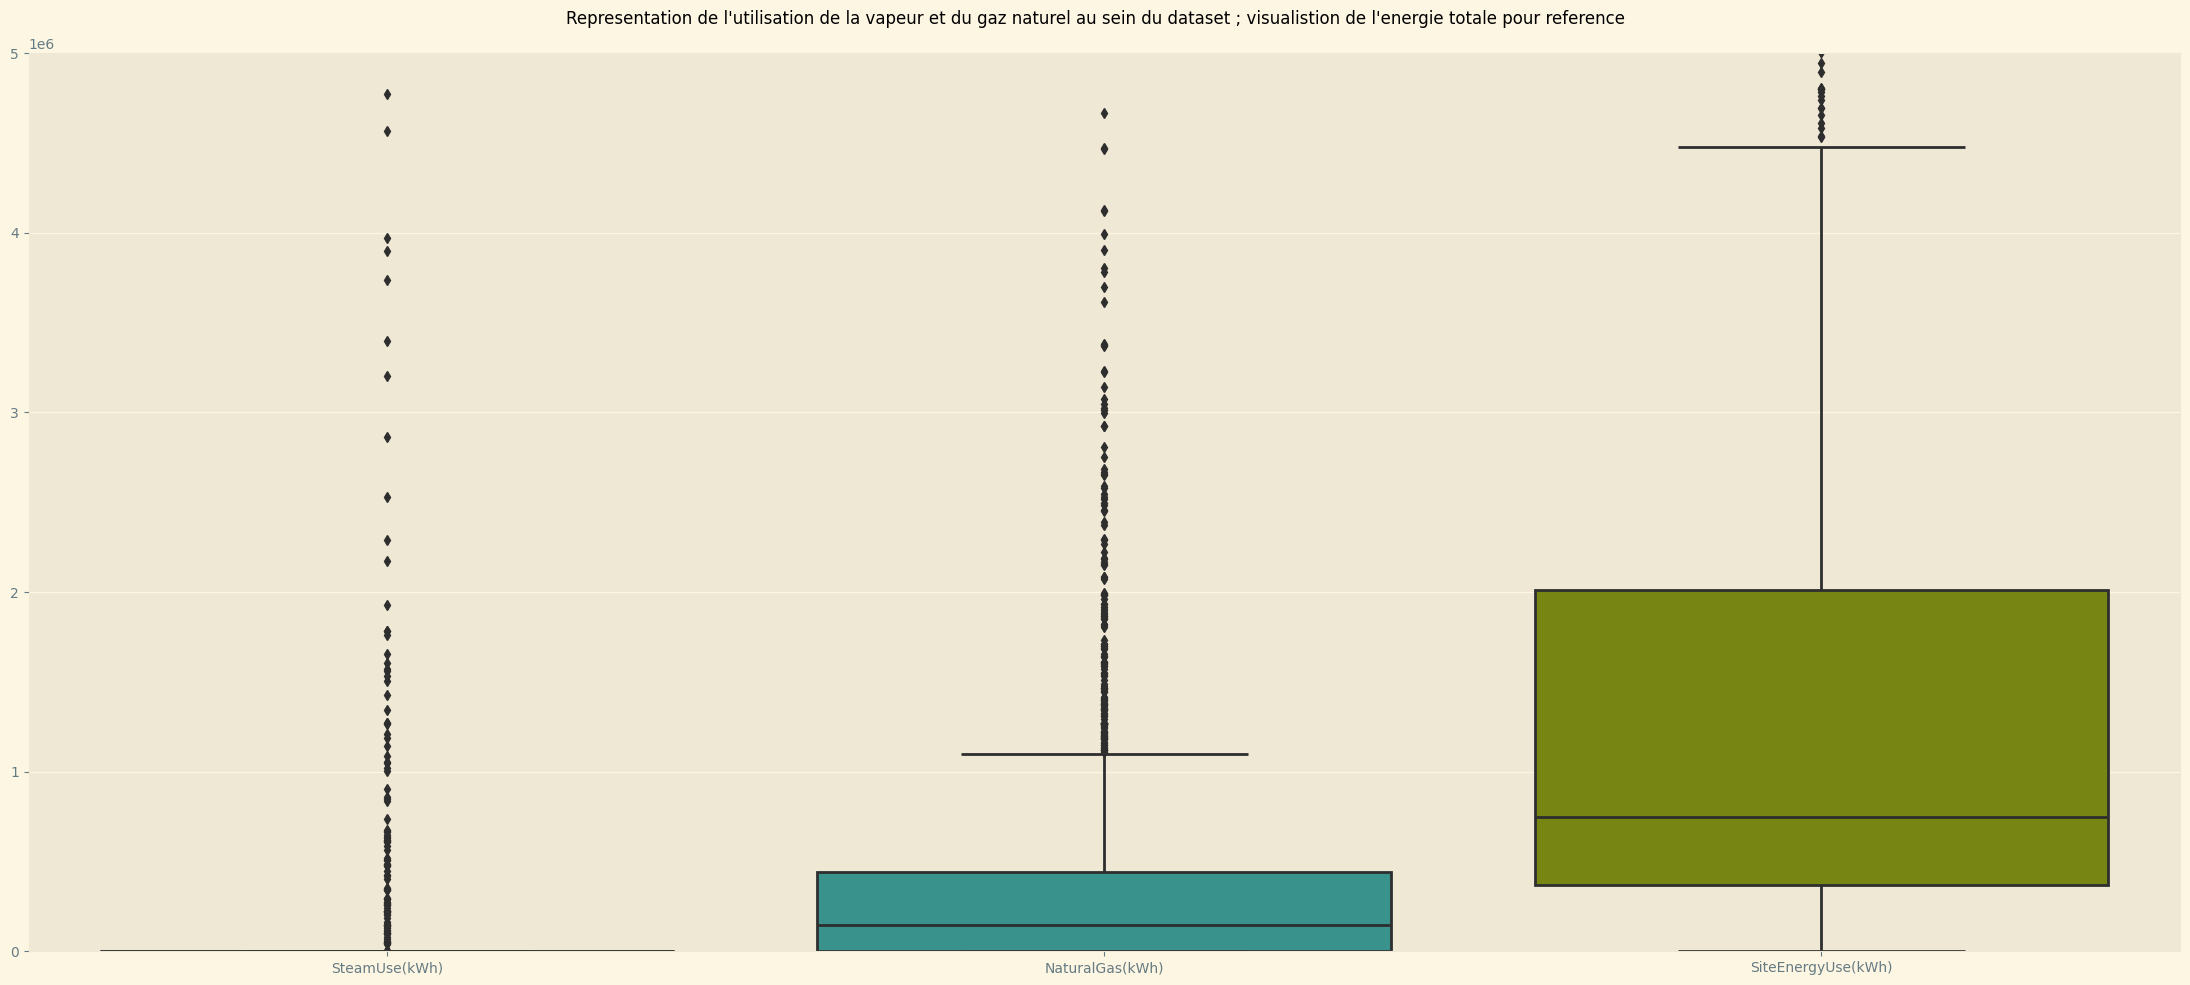

In [144]:
# Steam and Natural gas might be uncommon - Plotting ...

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(22, 10),
    dpi=pc_dpi,
)

ax1 = sns.boxplot(
    data=df_seattle[["SteamUse(kWh)", "NaturalGas(kWh)", "SiteEnergyUse(kWh)"]]
)


###
# Titles/Lables

ax1.set_ylim(0, 0.5 * 1e7)
fig.suptitle("Representation de l'utilisation de la vapeur et du gaz naturel au sein du dataset\
 ; visualistion de l'energie totale pour reference")
#
###
fig.tight_layout()
plt.show()


### Observation : 
- On peut constater que l'utilisation de la vapeur est très marginale
- Le gaz naturel est, quant à lui, significatif (? chauffage/electromenager ?)
--> Suppression de la vapeur seule

In [145]:
columns_pca.remove("SteamUse(kWh)")
df_seattle.drop(columns=["SteamUse(kWh)"], inplace=True)


/var/folders/3s/s8sp6jwn6qs02jfxbgjc7c_40000gn/T/ipykernel_96221/689506885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seattle.drop(columns=["SteamUse(kWh)"], inplace=True)


In [146]:
columns_pca

['NumberofFloors',
 'Electricity(kWh)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'PropertyArea(SquareMetre)Total',
 'PropertyArea(SquareMetre)Parking',
 'PropertyArea(SquareMetre)Building(s)',
 'SecondLargestPropertyUseTypeArea(SquareMetre)',
 'SourceEUI(kWh/m2)',
 'SourceEUIWN(kWh/m2)',
 'NaturalGas(kWh)']

## PCA_2 : Useful var only

In [147]:
data_pca = df_seattle[columns_pca]

data_pca = data_pca.astype(float)  # All values are forced converted to float, as the columns above (columns_pca) are all numeric

data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = df_seattle.index
features = columns_pca

scaled_data = preprocessing.scale(data_pca)
pca_two = PCA(n_components=len(columns_pca))
pca_two.fit(scaled_data)
pca_data = pca_two.transform(scaled_data)
percentage_variation = np.round(pca_two.explained_variance_ratio_ * 100, decimals=1)

pcs = pca_two.components_


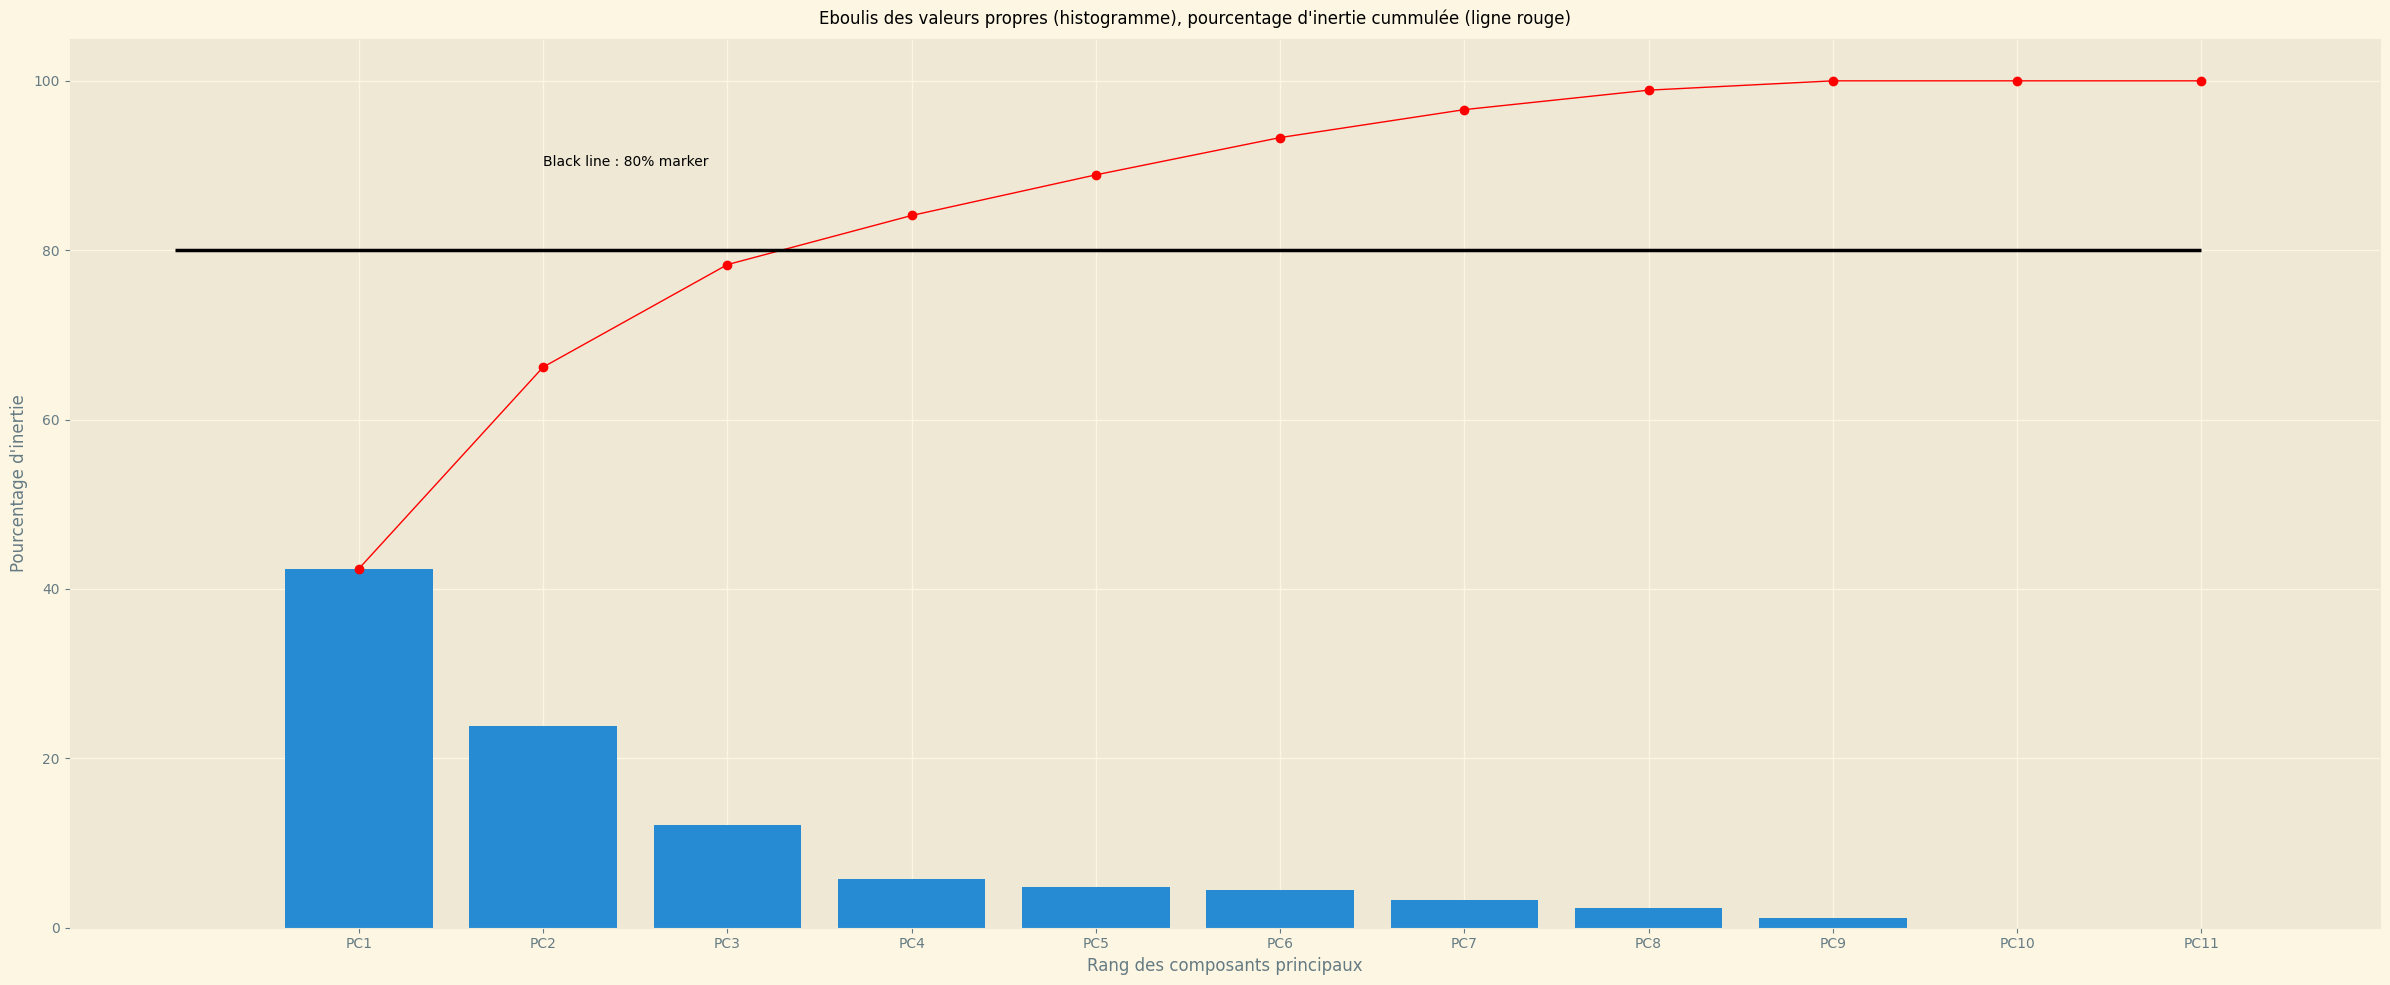

In [148]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(24, 10),
    dpi=pc_dpi,
)

x_bars = np.arange(1, len(percentage_variation) + 1, 1)

cummulative_percentage = np.cumsum(percentage_variation)

ax1.bar(x_bars, height=percentage_variation)  # Inertia Scree

###
# Titles/Lables
labels = ["PC" + str(c) for c in range (1, len(percentage_variation) + 1)]
ax1.set_xticks(range(1, len(labels) + 1, 1))
ax1.set_xticklabels(labels)
ax1.set_xlabel("Rang des composants principaux")
ax1.set_ylabel("Pourcentage d'inertie")
fig.suptitle("Eboulis des valeurs propres (histogramme), pourcentage d'inertie cummulée (ligne rouge)")
ax1.text(2,90,'Black line : 80% marker')
#
###

ax1.plot(ax1.get_xticks(), cummulative_percentage, marker="o", color="r", linewidth=1)  # Cumulative Inertia
ax1.plot(np.arange(0, len(cummulative_percentage) + 1, 1), [80 for _ in range(0, len(cummulative_percentage) + 1)], color="0", linewidth=2.5)
fig.tight_layout()

plt.show()


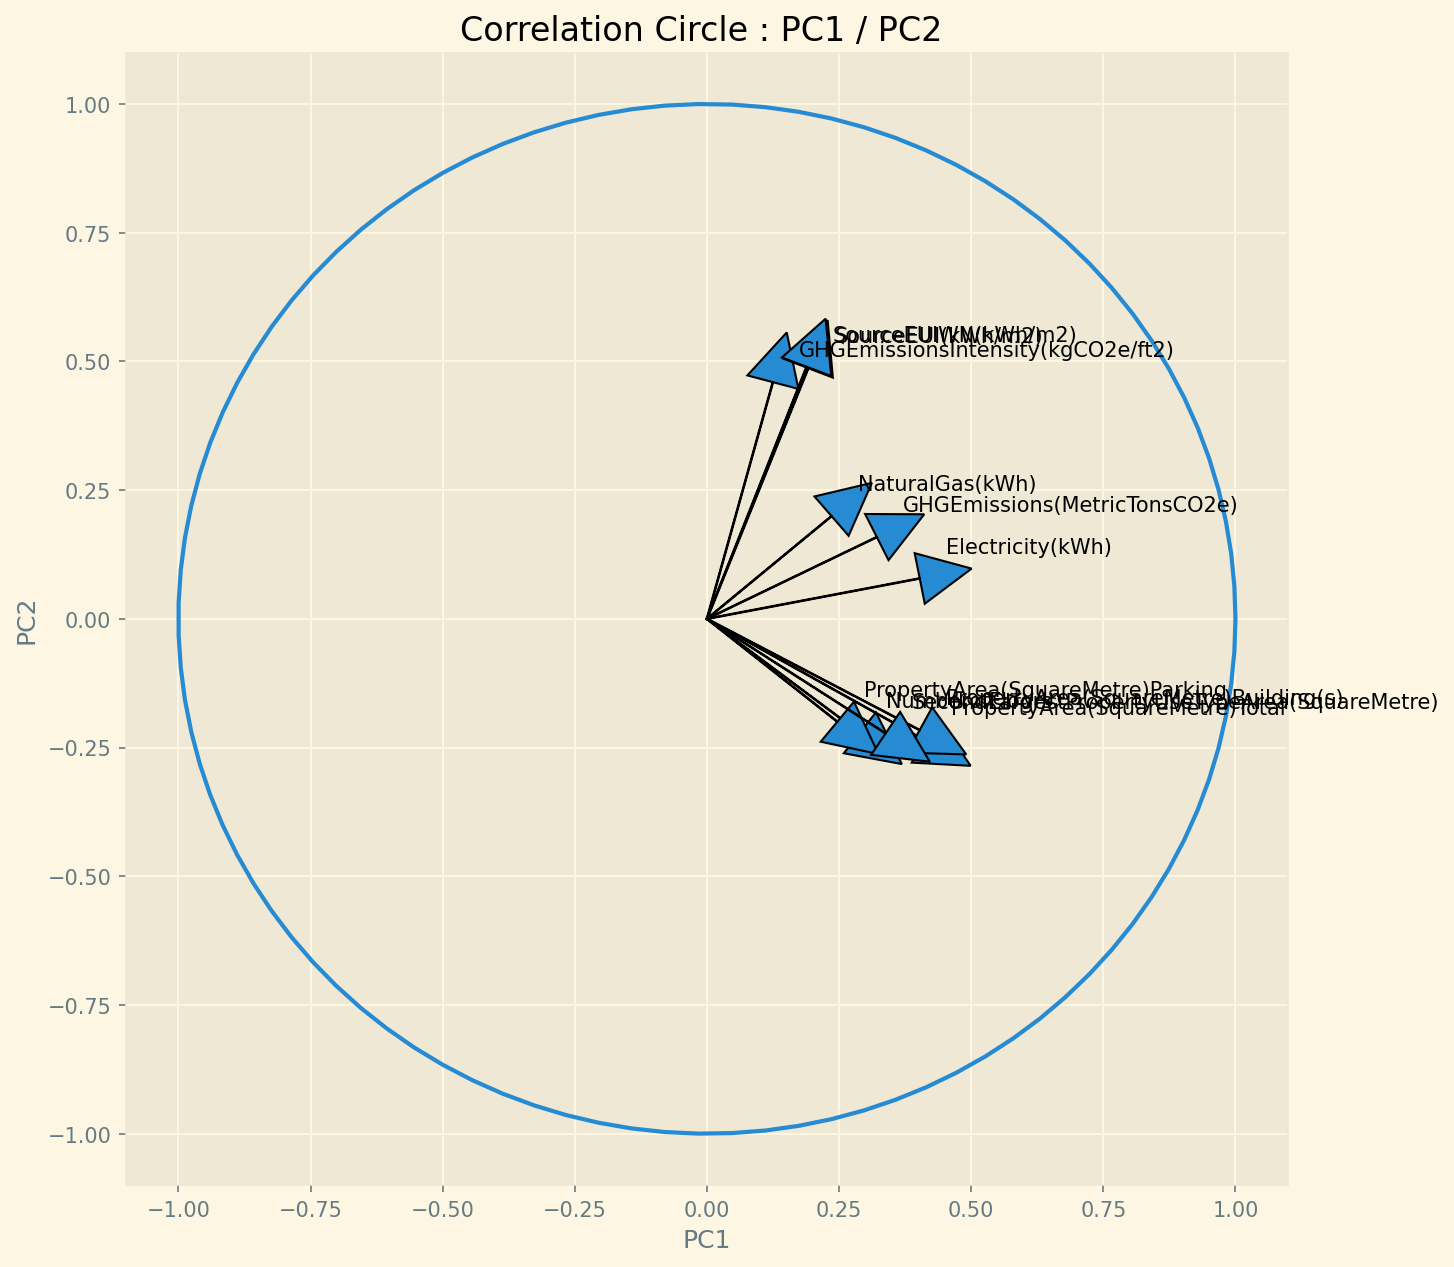

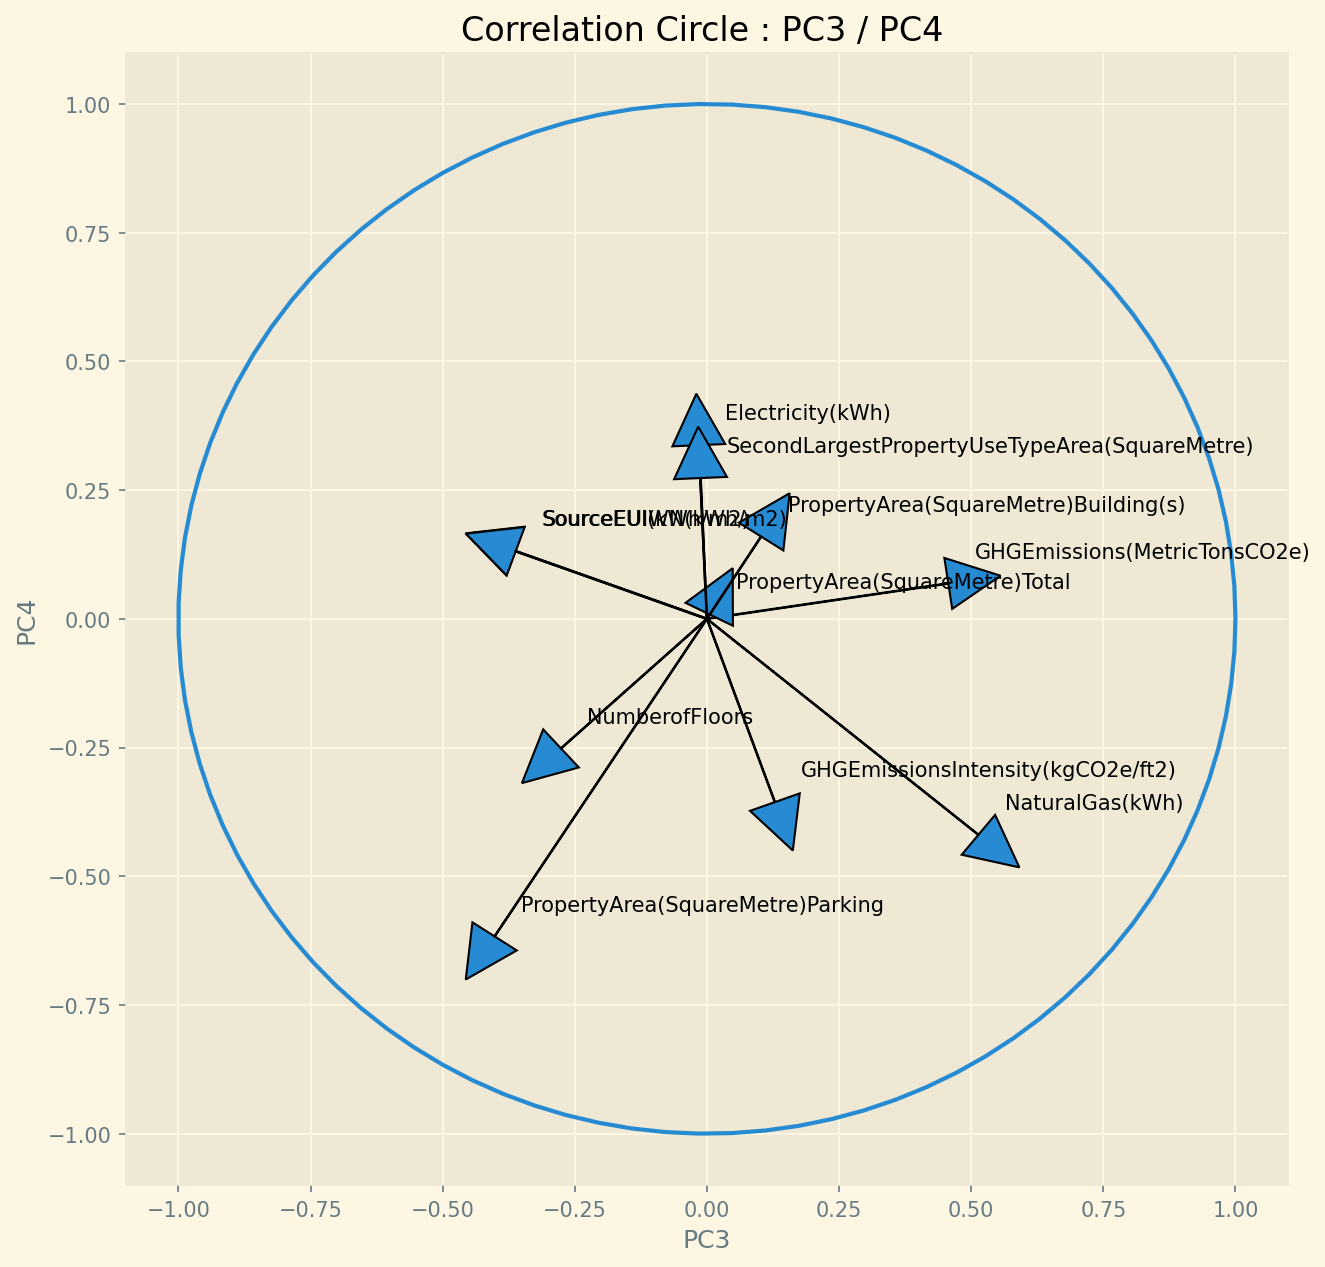

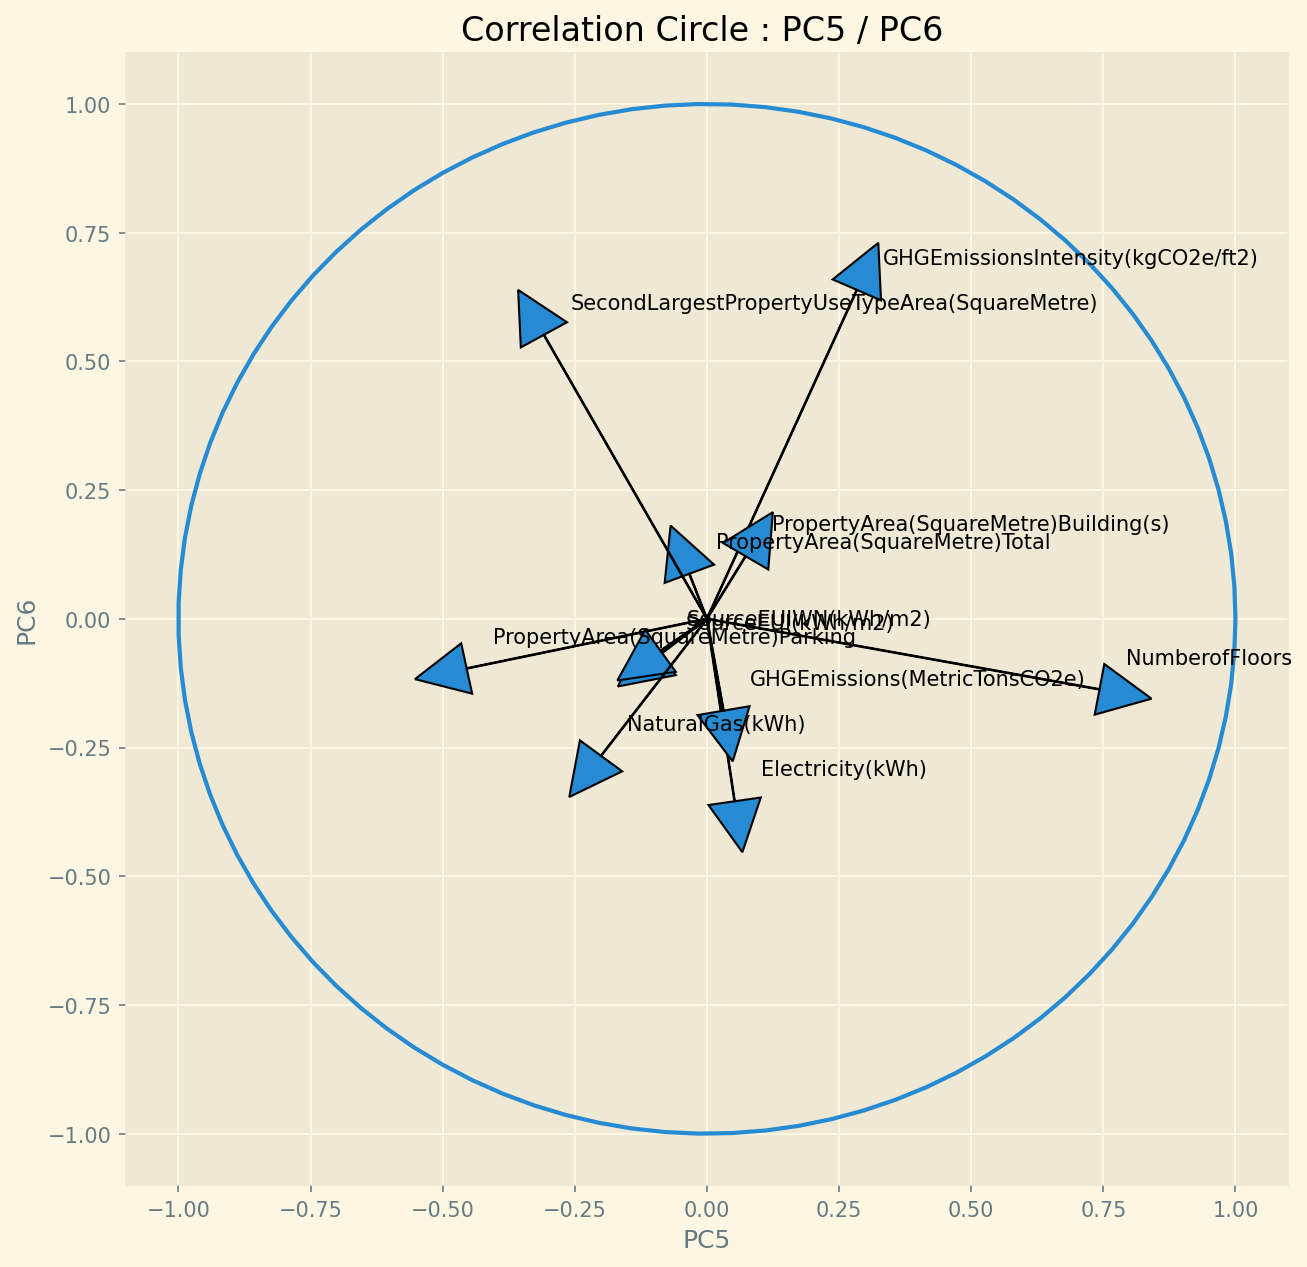

In [149]:
couples = [(0, 1), (2, 3), (4, 5)]

for couple in couples:
    display_circles(pca=pca_two, pca_cols=columns_pca, couple_pc=couple)


In [150]:
pca_two_explained_df = show_contribution(pca=pca_two, columns_pca=columns_pca, lim_pc=4)
pca_two_explained_df


,PC1,PC2,PC3,PC4
NumberofFloors,0.289397,-0.221357,-0.276056,-0.251688
Electricity(kWh),0.402655,0.078463,-0.015386,0.337316
GHGEmissions(MetricTonsCO2e),0.321491,0.158790,0.456712,0.068776
GHGEmissionsIntensity(kgCO2e/ft2),0.124832,0.459713,0.128595,-0.356009
PropertyArea(SquareMetre)Total,0.412249,-0.235864,0.004377,0.008806
PropertyArea(SquareMetre)Parking,0.246778,-0.199790,-0.401692,-0.616787
PropertyArea(SquareMetre)Building(s),0.402526,-0.216056,0.102561,0.159819
SecondLargestPropertyUseTypeArea(SquareMetre),0.338139,-0.222487,-0.012057,0.273454
SourceEUI(kWh/m2),0.191786,0.486826,-0.362826,0.131848
SourceEUIWN(kWh/m2),0.188610,0.489653,-0.361762,0.131283
